<a href="https://colab.research.google.com/github/aldo-arevalo/mimic-code/blob/master/notebooks/ICUglycemia/Notebooks/1_0_ara_data_curation_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data extraction and Pairing of Insulin Inputs to Glucose Measurements in the ICU
## Interactive notebook: Part I

Authors: [Aldo Robles Arévalo](mailto:aldo.arevalo@tecnico.ulisboa.pt); Jason Maley; Lawrence Baker; Susana M. da Silva Vieira; João M. da Costa Sousa; Stan Finkelstein; Roselyn Mateo-Collado; Jesse D. Raffa; Leo A. Celi; Francis DeMichele.

## Overview

This notebook contains the curation and pre-processing process to extract glucose readings and insulin inputs from the Medical Information Mart for Intensive Care (MIMIC). This notebook is complemented with the notebook entitled *2.0-ara-pairing-II.ipynb*.


## General instructions
To perform the queries, do not forget to specify your project ID that grants you access to the MIMIC database hosted in *bigQuery*. Substitute `projectid` variable with the name of that project. In case you want to save the dataframes to your *BigQuery* project, uncomment and substitute `your_dataset` with the name of your *BigQuery* dataset and execute.

You can also save the created dataframes and figures in your Google Drive account. After mounting your drive, substitute `base_dir` variable with the path of the folder where you want to save them. In this notebook that folder was named `Insulin Therapy ICU` and `MyDrive` is the parent folder. Figures are saved in the path *Insulin Therapy ICU/DataExtraction/MIMIC_III/Figures/*, you should change it according to your needs or create the folders with the exact names in your Google Drive.

# Code



## Import dependencies and libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.colors as colors
from scipy import stats
from datetime import datetime
import time
import warnings

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML, Math, Latex

# Imports for accessing data using Google BigQuery.
from google.cloud import bigquery
from google.colab import files, auth
auth.authenticate_user()
print('Authenticated')
%load_ext google.colab.data_table

# Function to submit a query to BigQuery
def q(query,projectid):
    client = bigquery.Client(location="US",project=projectid)
    # Location must match that of the dataset(s) referenced in the query.
    query_job = client.query(query,
    location="US",)  # API re
    return query_job.to_dataframe()

# Function to round floats (for heatmap plot).
def myround(x, base):
    return int(base * round(float(x)/base))

# Function to coerse columns with corrupted datetime data.
def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col])
    
    return(df)

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


/usr/local/lib/python3.6/dist-packages/google/colab/auth.py:141: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 51274), raddr=('172.217.214.95', 443)>
  if _check_adc():


## Mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# Specify the path to your own folder BELOW
base_dir = "/content/gdrive/My Drive/Insulin Therapy ICU"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Verify client name (*BigQuery*)


In [ ]:
projectid = "hst-953-2019" # <-- Your project ID
client = bigquery.Client(location="US",project=projectid)
print("Client creating using default project: {}".format(client.project))

Client creating using default project: hst-953-2019


## Extraction of insulin events

The following item id's are extracted

| Item id | Insulin type |
|---------|:------------:|
| 223257  |'Intermediate'|
| 223258  |   'Short'    |
| 223259  |'Intermediate'|
| 223260  |   'Long'     |
| 223261  |'Intermediate'|
| 223262  |   'Short'    |

In [ ]:
# Import Insulin input raw

query="""
SELECT atr.SUBJECT_ID, atr.HADM_ID, atr.ICUSTAY_ID
    , CAST(atr.starttime AS TIMESTAMP) AS STARTTIME
    , CAST(atr.endtime AS TIMESTAMP) AS ENDTIME
    , atr.AMOUNT, atr.RATE, atr.ORIGINALRATE, atr.ITEMID, atr.ORDERCATEGORYNAME
    , (CASE
        WHEN itemid=223257 THEN 'Intermediate' --'Ins7030'
        WHEN itemid=223258 THEN 'Short'        --'InsRegular'
        WHEN itemid=223259 THEN 'Intermediate' --'InsNPH'
        WHEN itemid=223260 THEN 'Long'         --'InsGlargine'
        WHEN itemid=223261 THEN 'Intermediate' --'InsHum7525'
        WHEN itemid=223262 THEN 'Short'        --'InsHum'
        ELSE null END) AS InsulinType
    , (CASE
        WHEN UPPER(ORDERCATEGORYNAME) LIKE '%NON IV%' THEN 'BOLUS_INYECTION'
        WHEN UPPER(ORDERCATEGORYNAME) LIKE '%MED BOLUS%' THEN 'BOLUS_PUSH'
        WHEN ORDERCATEGORYNAME IN ('01-Drips','12-Parenteral Nutrition') THEN 'INFUSION'
        ELSE null END) AS InsulinAdmin
    , (CASE WHEN STATUSDESCRIPTION IN ('Paused','Stopped') THEN 1 ELSE 0 END) AS INFXSTOP
FROM `physionet-data.mimiciii_clinical.inputevents_mv` atr								
WHERE itemid IN (223257   -- [Ins7030]     - Insulin 70/30 
                , 223258  -- [InsRegular]  - Insulin Regular
                , 223259  -- [InsNPH]      - Insulin NPH
                , 223260  -- [InsGlargine] - Insulin Glargine
                , 223261  -- [nsHum7525]   - Insulin Humalog 75/25
                , 223262) -- [InsHum]      - Insulin Humalog
    AND atr.statusdescription != 'Rewritten' --Exclude invalid measures that were rewritten
GROUP BY atr.subject_id, atr.hadm_id, atr.icustay_id, atr.starttime
    , atr.endtime, atr.ITEMID, atr.ordercategoryname
    , atr.statusdescription, atr.amount, atr.rate, atr.ORIGINALRATE
ORDER BY atr.icustay_id, atr.subject_id, atr.hadm_id, atr.starttime
"""

insulin_mv = q(query,projectid)

display(insulin_mv.head())

/usr/local/lib/python3.6/dist-packages/pandas/core/common.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 43070), raddr=('74.125.126.95', 443)>
  value = tslibs.Timestamp(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/common.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=83, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 49924), raddr=('108.177.112.95', 443)>
  value = tslibs.Timestamp(value)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
0,963,190225,NaN,2204-10-26 12:29:00+00:00,2204-10-26 12:30:00+00:00,2.000000,NaN,2.0,223258,05-Med Bolus,Short,BOLUS_PUSH,0
1,963,190225,NaN,2204-10-26 12:29:00+00:00,2204-10-26 13:54:00+00:00,2.833333,2.000000,2.0,223258,01-Drips,Short,INFUSION,0
2,963,190225,NaN,2204-10-26 13:54:00+00:00,2204-10-26 16:08:00+00:00,6.701149,3.000515,3.0,223258,01-Drips,Short,INFUSION,0
3,963,190225,NaN,2204-10-26 16:08:00+00:00,2204-10-26 18:11:00+00:00,2.050352,1.000171,1.0,223258,01-Drips,Short,INFUSION,0
4,963,190225,NaN,2204-10-26 18:11:00+00:00,2204-10-26 19:07:00+00:00,1.866987,2.000343,2.0,223258,01-Drips,Short,INFUSION,0


In [ ]:
# Coerse columns
insulin_mv[["ICUSTAY_ID","INFXSTOP","RATE","ORIGINALRATE"]] = insulin_mv[
        ["ICUSTAY_ID","INFXSTOP","RATE","ORIGINALRATE"]].apply(pd.to_numeric
        , errors='coerce')

boluses_raw = insulin_mv[(insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].shape[0]
boluses_intravenous_raw = insulin_mv[(insulin_mv['InsulinAdmin']=='BOLUS_PUSH')].shape[0]
boluses_subcutaneous_raw = insulin_mv[(insulin_mv['InsulinAdmin']=='BOLUS_INYECTION')].shape[0]
infusions_raw = insulin_mv[(insulin_mv['InsulinAdmin'] == 'INFUSION')].shape[0]
short_boluses_raw = insulin_mv[(insulin_mv['InsulinType']=="Short") &
                               (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].shape[0]
df_short_bol_raw = insulin_mv[(insulin_mv['InsulinType']=="Short") &
                               (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].copy()

# Save as CSV file; uncomment and modify as needed
#df_short_bol_raw.to_csv(base_dir+"/DataExtraction/MIMIC_III/BolusesRAW.csv", index=False, encoding='utf8', 
#                         header = True)

# Display results
display(HTML('<h5>It contains the following information</h5>'))
print("Entries: {}".format(insulin_mv.shape[0]))
print("Patients: {}".format(insulin_mv['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(insulin_mv['HADM_ID'].nunique()))
print('ICU stays: {}'.format(insulin_mv['ICUSTAY_ID'].nunique()))
print('Boluses: {}'.format(boluses_raw))
print('Boluses subcutaneous: {}'.format(boluses_subcutaneous_raw))
print('Boluses intravenous: {}'.format(boluses_intravenous_raw))
print('Infusions (regular): {}'.format(infusions_raw))
print('Regular boluses: {}'.format(short_boluses_raw))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(insulin_mv['ITEMID'].value_counts())

display(HTML('<h5>Verify column types</h5>'))
display(insulin_mv.dtypes)

# Entries: 151,201

Entries: 151201
Patients: 9638
Hospital admissions: 11236
ICU stays: 11882
Boluses: 105559
Boluses subcutaneous: 96204
Boluses intravenous: 9355
Infusions (regular): 45642
Regular boluses: 92936


223258    108237
223262     30341
223260      8641
223259      3383
223257       441
223261       158
Name: ITEMID, dtype: int64

SUBJECT_ID                         int64
HADM_ID                            int64
ICUSTAY_ID                       float64
STARTTIME            datetime64[ns, UTC]
ENDTIME              datetime64[ns, UTC]
AMOUNT                           float64
RATE                             float64
ORIGINALRATE                     float64
ITEMID                             int64
ORDERCATEGORYNAME                 object
InsulinType                       object
InsulinAdmin                      object
INFXSTOP                           int64
dtype: object

In [ ]:
# Drop missing ICU stays
# Data not taken during an ICU stay
insulin_mv = insulin_mv.dropna(subset=["ICUSTAY_ID"])

# Display results
display(HTML('<h5>It contains the following information</h5>'))
print("Observations: {}".format(insulin_mv.shape[0]))
print("Patients: {}".format(insulin_mv['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(insulin_mv['HADM_ID'].nunique()))
print('ICU stays: {}'.format(insulin_mv['ICUSTAY_ID'].nunique()))

display(insulin_mv.describe())

Observations: 151156
Patients: 9638
Hospital admissions: 11236
ICU stays: 11882


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,AMOUNT,RATE,ORIGINALRATE,ITEMID,INFXSTOP
count,151156.000000,151156.000000,151156.000000,151156.000000,44632.000000,151156.000000,151156.000000,151156.000000
mean,63093.411912,150538.832412,249874.687746,7.818743,5.663981,11.302837,223258.939771,0.047315
std,23339.520032,28648.123433,29008.491593,10.977985,12.097432,1956.415058,1.609845,0.212313
min,23.000000,100001.000000,200010.000000,0.000000,0.049999,0.000000,223257.000000,0.000000
25%,48204.000000,125843.000000,224516.000000,2.000000,2.001075,2.000000,223258.000000,0.000000
50%,64923.000000,150871.000000,250075.000000,4.000000,4.000000,4.000000,223258.000000,0.000000
75%,81923.000000,175448.000000,275509.000000,8.557214,6.034062,7.000000,223260.000000,0.000000
max,99992.000000,199979.000000,299998.000000,500.000015,1084.031880,760627.000000,223262.000000,1.000000


#### Extraction of infusions
Only short-acting infusions exist

In [ ]:
# Filter infusions
MV_infusions = insulin_mv[(insulin_mv['InsulinType']=="Short") & 
                      (insulin_mv['InsulinAdmin'].str.contains('INFUSION'))].copy(deep=True)

display(MV_infusions.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
118,74282,121149,200061.0,2134-01-23 23:08:00+00:00,2134-01-24 00:00:00+00:00,0.866667,1.000000,1.0,223258,01-Drips,Short,INFUSION,0
119,74282,121149,200061.0,2134-01-24 00:00:00+00:00,2134-01-24 01:00:00+00:00,2.000000,2.000000,2.0,223258,01-Drips,Short,INFUSION,0
120,74282,121149,200061.0,2134-01-24 01:00:00+00:00,2134-01-24 02:01:00+00:00,3.049477,2.999485,3.0,223258,01-Drips,Short,INFUSION,0
121,74282,121149,200061.0,2134-01-24 02:01:00+00:00,2134-01-24 03:05:00+00:00,5.333363,5.000028,5.0,223258,01-Drips,Short,INFUSION,0
122,74282,121149,200061.0,2134-01-24 03:05:00+00:00,2134-01-24 04:02:00+00:00,6.647539,6.997410,7.0,223258,01-Drips,Short,INFUSION,0


In [ ]:
# Display results
display(HTML('<h5>Statistics</h5>'))
display(MV_infusions[['RATE','ORIGINALRATE']].describe())

display(HTML('<h5>Infusions contains the following information</h5>'))
print("Observations: {}".format(MV_infusions.shape[0]))
print("Patients: {}".format(MV_infusions['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_infusions['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_infusions['ICUSTAY_ID'].nunique()))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_infusions['ITEMID'].value_counts())

,RATE,ORIGINALRATE
count,44632.000000,45623.000000
mean,5.663981,22.207227
std,12.097432,3561.058557
min,0.049999,0.000000
25%,2.001075,2.000000
50%,4.000000,4.000000
75%,6.034062,6.000000
max,1084.031880,760627.000000


Observations: 45623
Patients: 3621
Hospital admissions: 3829
ICU stays: 3879


223258    45623
Name: ITEMID, dtype: int64

##### RATE and ORIGINALRATE
Gather the missing rates and substantation of why *ORIGINALRATE* is not deviated from actual/measured rate.

In [ ]:
# Extract values that are NOT null
MV_infusion_notnull = MV_infusions.dropna(subset=['RATE']).copy(deep=True)
print("Null values: {}".format(MV_infusions.shape[0]-MV_infusion_notnull.shape[0]))

# Remove values > 2000 for plotting
df=MV_infusion_notnull[(MV_infusion_notnull.ORIGINALRATE < 2000)]

Null values: 991


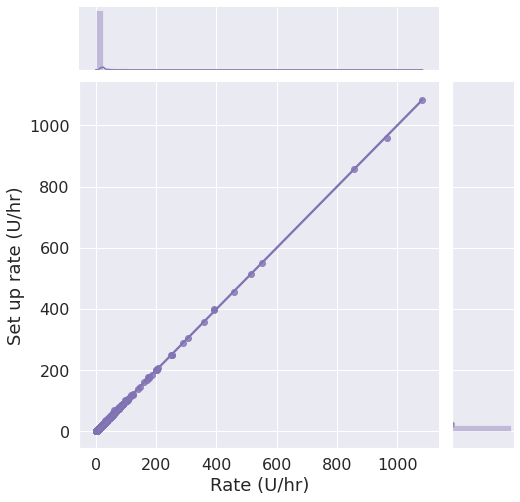

223258    45623
Name: ITEMID, dtype: int64

<IPython.core.display.Latex object>

MSE: 0.014


In [ ]:
sns.set(style="darkgrid", rc=None)

# JointPlot
sns.jointplot(x='RATE', y='ORIGINALRATE', data=df, kind='reg', color = 'm', height=7)
plt.xlabel('Rate (U/hr)', fontsize=18)
plt.ylabel('Set up rate (U/hr)', fontsize = 18)
ax = plt.gca()
ax.tick_params(labelsize = 16)

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_infusions['ITEMID'].value_counts())

# Correlation results
display(HTML('<h5>The correlation results are</h5>'))
display(Latex('$r^2$: {:.3f}'.format(r2_score(df.RATE, df.ORIGINALRATE))))
print('MSE: {:.3f}'.format(mean_squared_error(df.RATE, df.ORIGINALRATE)))

del df

In [ ]:
# Replace missing rates with original rate
MV_infusions['RATE'].fillna(MV_infusions['ORIGINALRATE'], inplace=True)
print("Observations after replacing RATE by ORIGINALRATE: {}".format(MV_infusions.shape[0]))
display(MV_infusions[['RATE','ORIGINALRATE']].describe())

# Extract values that are NOT null
MV_infusions = MV_infusions.dropna(subset=['RATE'])
print("Observations after removing nulls: {}".format(MV_infusions.shape[0]))

# Remove rates <= 0 U/hr
MV_infusions = MV_infusions[MV_infusions['RATE'] > 0]
print("Observations after removing rates <= 0 U/hr: {}".format(MV_infusions.shape[0]))

# Estimate 99th percentile for outlier removal
P99_infxn = MV_infusions['RATE'].quantile(.99)

# Drop boluses over 99th percentile
MV_infusions = MV_infusions[(MV_infusions['RATE'] < (MV_infusions['RATE'].quantile(.99)))]
print("Observations after removing inputs >99P: {}".format(MV_infusions.shape[0]))

# Display results
display(HTML('<h5>Short-acting infusions 99th percentile</h5>'))
display('P99: {:.3f}'.format(P99_infxn))

display(HTML('<h5>Statistics of doses</h5>'))
display(MV_infusions[['RATE']].describe())

display(HTML('<h5>Short-acting infusions contains the following updated information</h5>'))
print("Observations: {}".format(MV_infusions.shape[0]))
print("Patients: {}".format(MV_infusions['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_infusions['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_infusions['ICUSTAY_ID'].nunique()))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_infusions['ITEMID'].value_counts())

Observations after replacing RATE by ORIGINALRATE: 45623


,RATE,ORIGINALRATE
count,45623.000000,45623.000000
mean,5.541162,22.207227
std,11.993677,3561.058557
min,0.000000,0.000000
25%,2.000396,2.000000
50%,4.000000,4.000000
75%,6.011750,6.000000
max,1084.031880,760627.000000


Observations after removing nulls: 45623
Observations after removing rates <= 0 U/hr: 45088
Observations after removing inputs >99P: 44637


'P99: 29.816'

,RATE
count,44637.000000
mean,4.985555
std,4.164770
min,0.003418
25%,2.000681
50%,4.000000
75%,6.006266
max,29.812108


Observations: 44637
Patients: 3610
Hospital admissions: 3816
ICU stays: 3862


223258    44637
Name: ITEMID, dtype: int64

#### Extraction of boluses of short-acting insulin

In [ ]:
# Filter short-acting boluses
MV_bol_short = insulin_mv[(insulin_mv['InsulinType']=="Short") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].copy(deep=True)

display(MV_bol_short.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
45,11861,192256,200010.0,2132-08-05 10:00:00+00:00,2132-08-05 10:01:00+00:00,4.0,NaN,4.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
46,11861,192256,200010.0,2132-08-05 16:12:00+00:00,2132-08-05 16:13:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
47,11861,192256,200010.0,2132-08-05 21:28:00+00:00,2132-08-05 21:29:00+00:00,8.0,NaN,8.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
49,76603,179633,200024.0,2127-03-03 17:30:00+00:00,2127-03-03 17:31:00+00:00,10.0,NaN,10.0,223258,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
50,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0


In [ ]:
# Display results
display(HTML('<h5>Statistics of doses</h5>'))
display(MV_bol_short[['AMOUNT']].describe())

display(HTML('<h5>Short-acting boluses contains the following information</h5>'))
print("Observations: {}".format(MV_bol_short.shape[0]))
print("Patients: {}".format(MV_bol_short['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_bol_short['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_bol_short['ICUSTAY_ID'].nunique()))

,AMOUNT
count,92911.000000
mean,4.598449
std,4.240834
min,0.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,223.000000


Observations: 92911
Patients: 9496
Hospital admissions: 11029
ICU stays: 11652


In [ ]:
 # Remove doses <= 0 U
MV_bol_short = MV_bol_short[MV_bol_short['AMOUNT'] > 0]
print("Observarions after removing values < 0U: {}".format(MV_bol_short.shape[0]))

# Estimate 99th percentile for outlier removal
%store -d P99_bol_s
P99_bol_s = MV_bol_short['AMOUNT'].quantile(.99)
%store P99_bol_s

# Drop boluses over 99th percentile
MV_bol_short = MV_bol_short[(MV_bol_short['AMOUNT'] < (MV_bol_short['AMOUNT'].quantile(.99)))]
print("Observarions after removing values > 99P: {}".format(MV_bol_short.shape[0]))

# Display results
display(HTML('<h5>Short-acting boluses 99th percentile</h5>'))
display('P99: {:.2f}'.format(P99_bol_s))

display(HTML('<h5>Statistics of doses</h5>'))
display(MV_bol_short[['AMOUNT']].describe())

display(HTML('<h5>Short-acting boluses contains the following updated information</h5>'))
print("Observations: {}".format(MV_bol_short.shape[0]))
print("Patients: {}".format(MV_bol_short['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_bol_short['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_bol_short['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_short['ITEMID'].value_counts())

# Save dataframe as CSV file.
#MV_bol_short.to_csv(base_dir+"/DataExtraction/MIMIC_III/MV_bol_short.csv",index=False, encoding='utf8', header = True)

Observarions after removing values < 0U: 89593
Stored 'P99_bol_s' (float64)
Observarions after removing values > 99P: 88469


'P99: 18.00'

,AMOUNT
count,88469.000000
mean,4.517896
std,3.038117
min,0.100000
25%,2.000000
50%,4.000000
75%,6.000000
max,17.000000


Observations: 88469
Patients: 9370
Hospital admissions: 10877
ICU stays: 11484


223258    59847
223262    28622
Name: ITEMID, dtype: int64

#### Boluses of Intermediate-acting insulin

In [ ]:
# Filter intermediate-acting insulin
MV_bol_inter = insulin_mv[(insulin_mv['InsulinType']=="Intermediate") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].copy(deep=True)

print("Observations: {}".format(MV_bol_inter.shape[0]))
bol_inter_patients1 = MV_bol_inter['SUBJECT_ID'].unique()
display(MV_bol_inter.head())

Observations: 3982


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
248,50772,192069,200108.0,2110-12-10 18:00:00+00:00,2110-12-10 18:01:00+00:00,11.0,NaN,11.0,223257,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0
848,69110,131817,200636.0,2123-02-08 13:17:00+00:00,2123-02-08 13:18:00+00:00,4.0,NaN,4.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0
1022,4588,186721,200746.0,2113-03-04 10:29:00+00:00,2113-03-04 10:30:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0
1190,70148,195958,200924.0,2173-11-19 22:31:00+00:00,2173-11-19 22:32:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0
1191,70148,195958,200924.0,2173-11-20 10:39:00+00:00,2173-11-20 10:40:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0


In [ ]:
# Remove doses <= 0 U
MV_bol_inter = MV_bol_inter[MV_bol_inter['AMOUNT'] > 0]

# Display results
display(HTML('<h5>Statistics of doses</h5>'))
display(MV_bol_inter[['AMOUNT']].describe())

display(HTML('<h5>Intermediate-acting boluses contains the following information</h5>'))
print("Observations: {}".format(MV_bol_inter.shape[0]))
print("Patients: {}".format(MV_bol_inter['SUBJECT_ID'].nunique()))
bol_inter_patients2 = MV_bol_inter['SUBJECT_ID'].unique()
print("Hospital admissions: {}".format(MV_bol_inter['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_bol_inter['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_inter['ITEMID'].value_counts())

,AMOUNT
count,3962.000000
mean,18.572438
std,15.330288
min,1.000000
25%,8.000000
50%,15.000000
75%,25.000000
max,180.000000


Observations: 3962
Patients: 680
Hospital admissions: 781
ICU stays: 813


223259    3369
223257     437
223261     156
Name: ITEMID, dtype: int64

#### Boluses of Long-acting insulin

In [ ]:
# Filter long-acting insulin boluses
MV_bol_long = insulin_mv[(insulin_mv['InsulinType']=="Long") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].copy(deep=True)

print("Observations: {}".format(MV_bol_long.shape[0]))
bol_long_patients1 = MV_bol_long['SUBJECT_ID'].unique()
display(MV_bol_long.head())

Observations: 8640


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
48,11861,192256,200010.0,2132-08-05 21:29:00+00:00,2132-08-05 21:30:00+00:00,20.0,NaN,20.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0
51,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,40.0,NaN,40.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0
56,41710,181955,200028.0,2133-10-30 22:21:00+00:00,2133-10-30 22:22:00+00:00,66.0,NaN,66.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0
61,41710,181955,200028.0,2133-10-31 22:00:00+00:00,2133-10-31 22:01:00+00:00,66.0,NaN,66.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0
69,56369,198650,200033.0,2198-08-11 08:00:00+00:00,2198-08-11 08:01:00+00:00,10.0,NaN,10.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0


In [ ]:
# Remove doses <= 0 U
MV_bol_long = MV_bol_long[MV_bol_long['AMOUNT'] > 0]

display(HTML('<h5>Statistics of doses</h5>'))
display(MV_bol_long[['AMOUNT']].describe())

display(HTML('<h5>Long-acting boluses contains the following information</h5>'))
print("Observations: {}".format(MV_bol_long.shape[0]))
print("Patients: {}".format(MV_bol_long['SUBJECT_ID'].nunique()))
bol_long_patients2 = MV_bol_long['SUBJECT_ID'].unique()
print("Hospital admissions: {}".format(MV_bol_long['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_bol_long['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_long['ITEMID'].value_counts())

,AMOUNT
count,8626.000000
mean,23.377823
std,16.143641
min,1.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,180.000000


Observations: 8626
Patients: 2908
Hospital admissions: 3314
ICU stays: 3408


223260    8626
Name: ITEMID, dtype: int64

#### Counts for Intermadiate and Long acting insulin
For Figure 1 of the associated paper

In [ ]:
print("Patients long raw: {}".format(len(bol_long_patients1)))
print("Patients long curated: {}".format(len(bol_long_patients2)))
print("Patients intermediate raw: {}".format(len(bol_inter_patients1)))
print("Patients intermediate curated: {}".format(len(bol_inter_patients2)))

others_raw = np.concatenate((bol_long_patients1,bol_inter_patients1),axis=None)
others_cur = np.concatenate((bol_long_patients2,bol_inter_patients2),axis=None)

print("")
print("Patients others raw: {}".format(len(np.unique(others_raw))))
print("Patients others raw: {}".format(len(np.unique(others_cur))))

Patients long raw: 2909
Patients long curated: 2908
Patients intermediate raw: 682
Patients intermediate curated: 680

Patients others raw: 3396
Patients others raw: 3393


#### Merging boluses and infusions

In [ ]:
frames = [MV_bol_short, MV_bol_inter, MV_infusions, MV_bol_long]
MV_insulin_step6 = pd.concat(frames, sort = True, verify_integrity=True
                             , ignore_index=True, axis = 0)
cols = list(MV_bol_short.columns)
MV_insulin_step6 = MV_insulin_step6[cols]

del frames, cols

# Display first lines
display(MV_insulin_step6.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
0,11861,192256,200010.0,2132-08-05 10:00:00+00:00,2132-08-05 10:01:00+00:00,4.0,NaN,4.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
1,11861,192256,200010.0,2132-08-05 16:12:00+00:00,2132-08-05 16:13:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
2,11861,192256,200010.0,2132-08-05 21:28:00+00:00,2132-08-05 21:29:00+00:00,8.0,NaN,8.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
3,76603,179633,200024.0,2127-03-03 17:30:00+00:00,2127-03-03 17:31:00+00:00,10.0,NaN,10.0,223258,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
4,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0


In [ ]:
# Display counts and descriptive statistics
display(HTML('<h5>All insulin doses</h5>'))
display(MV_insulin_step6[['AMOUNT','RATE']].describe())

boluses_cur = MV_insulin_step6[(MV_insulin_step6['InsulinAdmin'].str.contains('BOLUS'))].shape[0]
boluses_intravenous_cur = MV_insulin_step6[(MV_insulin_step6['InsulinAdmin']=='BOLUS_PUSH')].shape[0]
boluses_subcutaneous_cur = MV_insulin_step6[(MV_insulin_step6['InsulinAdmin']=='BOLUS_INYECTION')].shape[0]
infusions_cur = MV_insulin_step6[(MV_insulin_step6['InsulinAdmin'] == 'INFUSION')].shape[0]

# Display results
display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(MV_insulin_step6.shape[0]))
print("Patients: {}".format(MV_insulin_step6['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_insulin_step6['HADM_ID'].nunique()))
print('ICU stays: {}'.format(MV_insulin_step6['ICUSTAY_ID'].nunique()))
print('Boluses: {}'.format(boluses_cur))
print('Boluses subcutaneous: {}'.format(boluses_subcutaneous_cur))
print('Boluses intravenous: {}'.format(boluses_intravenous_cur))
print('Infusions: {}'.format(infusions_cur))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_insulin_step6['ITEMID'].value_counts())

# Administration route
display(HTML('<h5>Administration routes:</h5>'))
display(MV_insulin_step6['InsulinAdmin'].value_counts())

,AMOUNT,RATE
count,145694.000000,44637.000000
mean,7.635717,4.985555
std,9.840601,4.164770
min,0.000833,0.003418
25%,2.000000,2.000681
50%,4.000000,4.000000
75%,8.246813,6.006266
max,180.000000,29.812108


Observations: 145694
Patients: 9518
Hospital admissions: 11094
ICU stays: 11725
Boluses: 101057
Boluses subcutaneous: 91756
Boluses intravenous: 9301
Infusions: 44637


223258    104484
223262     28622
223260      8626
223259      3369
223257       437
223261       156
Name: ITEMID, dtype: int64

BOLUS_INYECTION    91756
INFUSION           44637
BOLUS_PUSH          9301
Name: InsulinAdmin, dtype: int64

## Glucose readings

The following item id's were identified:

| Item id | Description                 | Source    |
|:-------:|-----------------------------|:---------:|
| 807     |Fingerstick Glucose          |CHARTEVENTS|
| 811     | Glucose (70-105)            |CHARTEVENTS|
| 1529    | Glucose                     |CHARTEVENTS|
| 3745    | BloodGlucose                |CHARTEVENTS|
| 3744    | Blood Glucose               |CHARTEVENTS|
| 225664  | Glucose finger stick        |CHARTEVENTS|
| 220621  | Glucose (serum)             |CHARTEVENTS|
| 226537  | Glucose (whole blood)       |CHARTEVENTS|
| 50931   | GLUCOSE CHEMISTRY BLOOD     |LABEVENTS  |
| 50809   | GLUCOSE BLOOD GAS BLOOD)    |LABEVENTS  |

In [ ]:
warnings.simplefilter('ignore')

# Import raw glucose readings
query="""
WITH chart AS(  -- Import data stored in CHARTEVENTS table
    SELECT ce.subject_id, ce.hadm_id, ce.icustay_id, ce.charttime, ce.storetime
    , (CASE
            WHEN itemid IN (811,1529,3745,3744,220621,226537,807,225664)
            AND ce.valuenum > 0 THEN valuenum            
            ELSE null END) AS Glu_Chart
    , ce.itemid, 1 AS idi
    FROM `physionet-data.mimiciii_clinical.chartevents` ce
    WHERE ce.itemid IN(807,     --  Fingerstick Glucose
                        811,    --	Glucose (70-105)
                        1529,   --	Glucose
                        3745,   --	BloodGlucose
                        3744,   --	Blood Glucose
                        225664, --	Glucose finger stick
                        220621, --	Glucose (serum)
                        226537  --	Glucose (whole blood)
                        )
    AND (ce.error IS null OR ce.error <> 1)
)
, labv AS( -- Import data stored in LABEVENTS table
    SELECT le.SUBJECT_ID, le.HADM_ID, le.CHARTTIME 
    , (CASE
            WHEN itemid IN (50809,50931) AND valuenum > 0
            THEN valuenum ELSE null END) AS Glu_Labv
    , itemid, 2 AS idi
    FROM `physionet-data.mimiciii_clinical.labevents` le	 
    WHERE le.itemid IN(50931     -- GLUCOSE | CHEMISTRY | BLOOD 
                        , 50809) -- GLUCOSE | BLOOD GAS | BLOOD)
)
-- Join both tables/sources

SELECT pt.SUBJECT_ID, pt.HADM_ID, pt.ICUSTAY_ID
    , CAST(pt.CHARTTIME AS TIMESTAMP) AS CHARTTIME
    , CAST(pt.STORETIME AS TIMESTAMP) AS STORETIME
    , pt.glucose
    , COALESCE(pt.CH, pt.LB) AS ITEM_GLC
FROM (
    -- Call the temporary table LABV
    SELECT subject_id, hadm_id, null AS icustay_id, charttime
    , null AS storetime, glu_labv AS glucose, itemid AS LB, null AS CH 
    FROM labv AS le

    UNION DISTINCT

    -- Call the temporary table CHART                    
    SELECT subject_id, hadm_id, icustay_id, charttime, storetime, Glu_Chart, null
    , itemid FROM chart as ce
) pt
WHERE pt.glucose IS NOT null
GROUP BY pt.subject_id,pt.hadm_id,pt.ICUSTAY_ID,pt.charttime,pt.STORETIME,glucose,pt.CH,pt.LB
ORDER BY subject_id,hadm_id,ICUSTAY_ID,charttime 
"""

Glucose = q(query,projectid)

del query

# Coerse columns
Glucose[["CHARTTIME","STORETIME"]] = Glucose[
    ["CHARTTIME","STORETIME"]].apply(pd.to_datetime, format='%Y%m%d %H:%M:%S')

# Display first rows
display(Glucose.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,STORETIME,glucose,ITEM_GLC
0,2,163353.0,243653.0,2138-07-17 20:30:00+00:00,2138-07-17 22:07:00+00:00,72.0,3745
1,3,NaN,NaN,2101-10-04 15:24:00+00:00,NaT,121.0,50931
2,3,NaN,NaN,2101-10-05 06:00:00+00:00,NaT,116.0,50931
3,3,NaN,NaN,2101-10-06 05:45:00+00:00,NaT,94.0,50931
4,3,NaN,NaN,2101-10-07 04:30:00+00:00,NaT,92.0,50931


In [ ]:
# Display information
display(HTML('<h5>Description of all glucose readings</h5>'))
display(Glucose[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose.shape[0]))
print("Patients: {}".format(Glucose['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose['ITEM_GLC'].value_counts())

,glucose
count,2.508737e+06
mean,1.377641e+02
std,8.947669e+02
min,1.060000e-01
25%,1.030000e+02
50%,1.250000e+02
75%,1.550000e+02
max,9.999990e+05


Observations: 2508737
Patients: 41395
Hospital admissions: 53078
ICU stays: 54601


50931     748747
807       431010
811       374668
1529      283795
225664    246001
50809     196591
220621    154525
226537     70231
3745        2639
3744         530
Name: ITEM_GLC, dtype: int64

#### Item id's distributions


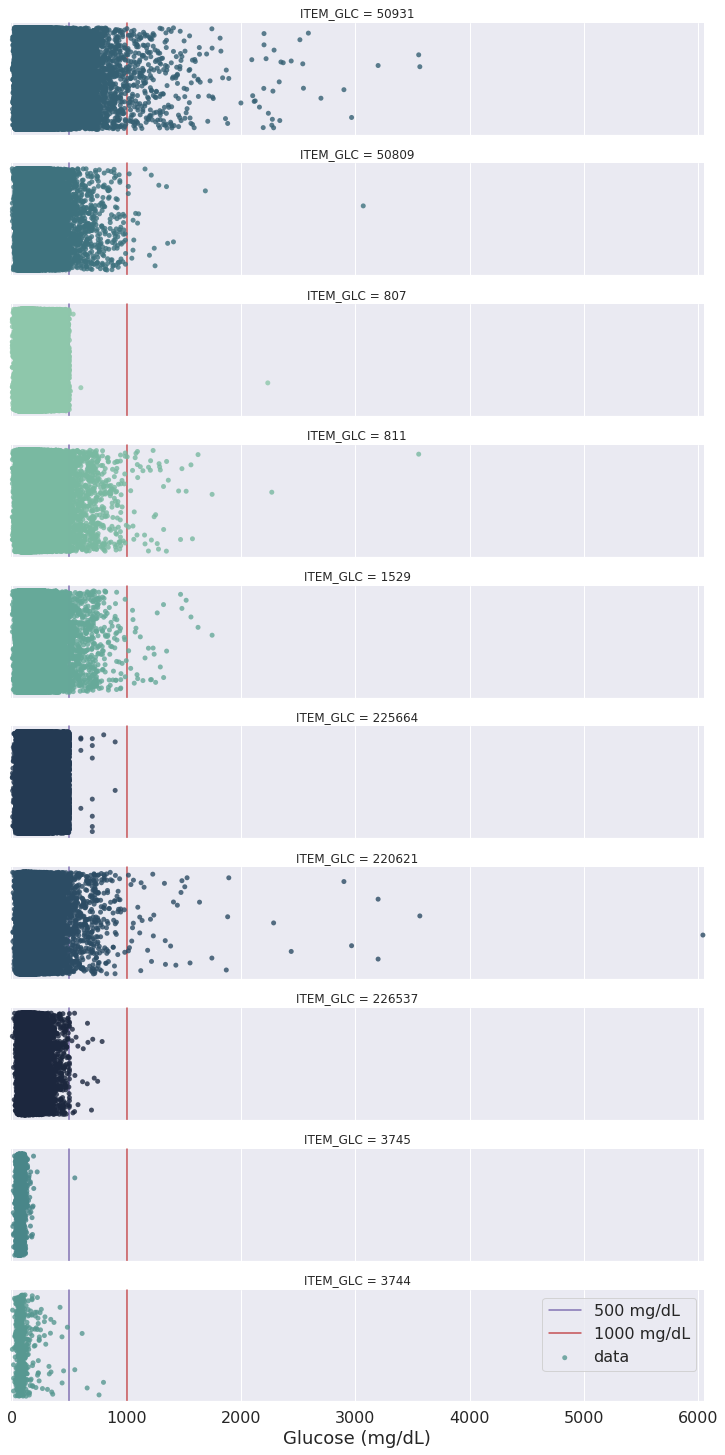

In [ ]:
# Initialize the FacetGrid object
sns.set(style="darkgrid", rc=None)

# Plot
pal = sns.cubehelix_palette((Glucose['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose[Glucose.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, row_order=[50931,50809,807,811,1529
                                                                          ,225664,220621,226537
                                                                          ,3745,3744]
                 , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose.glucose[Glucose.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

In [ ]:
# Include patients that have insulin info
insulin_mv_patients = list(MV_insulin_step6.HADM_ID.dropna().unique())

Glucose_tmp = Glucose[Glucose['HADM_ID'].isin(insulin_mv_patients)].copy()

#Save as CSV file, uncomment and modify as needed.
#Glucose_tmp[['SUBJECT_ID','ICUSTAY_ID','CHARTTIME',
#             'glucose']].to_csv(base_dir+"/DataExtraction/MIMIC_III/GlucoseRAW.csv", index=False, encoding='utf8', header = True)

,glucose
count,592561.000000
mean,150.957631
std,1838.141335
min,0.133000
25%,110.000000
50%,133.000000
75%,167.000000
max,999999.000000


'Raw for insulin patients: 295470.68'

'Raw for insulin patients: 543.21'

Readings (raw) per hospital stay: 53.41 +/- 64.01


Time lapse (hr) between raw readings/HADM stay: 3.57 +/- 4.86


Entries: 592561
Patients: 9518
Hospital admissions: 11094
ICU stays: 12224


225664    219065
50931     158781
220621     98046
226537     58425
50809      51078
1529        3020
811         3020
807         1126
Name: ITEM_GLC, dtype: int64

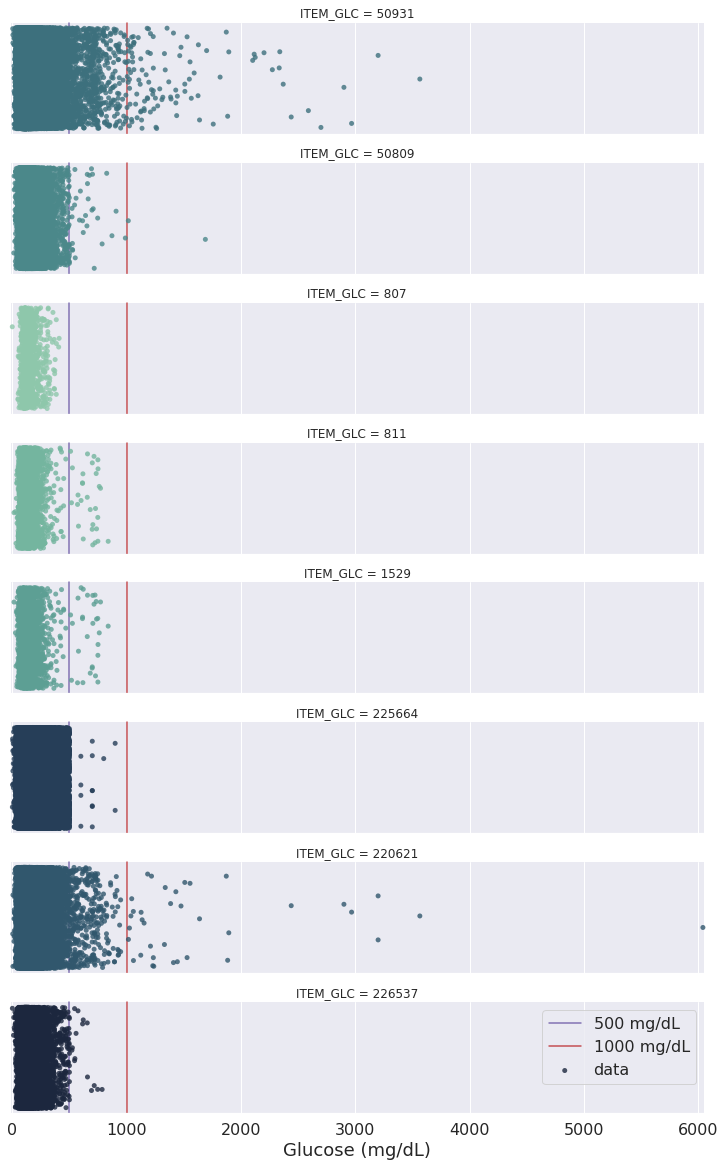

In [ ]:
# Display statistics (updated)
display(HTML('<h4>Statistics of all glucose readings</h4>'))
display(Glucose_tmp[['glucose']].describe())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h4>Excess Kurtosis</h4>'))
# positive kurtosis indicates a "heavy-tailed" distribution and negative kurtosis indicates 
# a "light tailed" distribution.
display("Raw for insulin patients: {:.2f}".format(stats.kurtosis(Glucose_tmp['glucose'],
                                                                 axis=0, fisher=True, 
                                                                 bias=True, 
                                                                 nan_policy='omit')))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h4>Fisher-Pearson coefficient of skewness</h4>'))
display("Raw for insulin patients: {:.2f}".format(stats.skew(Glucose_tmp['glucose'],
                                                             axis=0, bias=False, 
                                                             nan_policy='omit')))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
countGLCraw = Glucose_tmp.groupby('HADM_ID').count().glucose.copy()

display(HTML('<h4>Readings per hospital stay<h4>'))
print("Readings (raw) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLCraw.mean(),
                                                                     countGLCraw.std()))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_both_raw = Glucose_tmp.copy(deep=True)
df_both_raw['diff'] = df_both_raw.sort_values(['HADM_ID',
                                               'CHARTTIME']).groupby('HADM_ID')['CHARTTIME'].diff().copy()
df_both_raw['diff_hr']= df_both_raw['diff'].dt.seconds/3600

display(HTML('<h4>Time lapse between readings<h4>'))
print("Time lapse (hr) between raw readings/HADM stay: {:0.2f} +/- {:0.2f}".format(
    df_both_raw['diff_hr'].mean(),df_both_raw['diff_hr'].std()))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(Glucose_tmp.shape[0]))
print("Patients: {}".format(Glucose_tmp['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_tmp['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_tmp['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_tmp['ITEM_GLC'].value_counts())

# Plot
pal = sns.cubehelix_palette((Glucose_tmp['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose_tmp[Glucose_tmp.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, 
    row_order=[50931,50809,807,811,1529,225664,220621,226537]
                 , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose_tmp.glucose[Glucose_tmp.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

,glucose
count,537155.000000
mean,151.983887
std,1930.510113
min,0.133000
25%,110.000000
50%,134.000000
75%,168.000000
max,999999.000000


Entries: 537155
Patients: 9518
Hospital admissions: 11094
ICU stays: 12224


225664    218975
50931     123026
220621     97622
226537     58386
50809      35173
811         1425
1529        1423
807         1125
Name: ITEM_GLC, dtype: int64

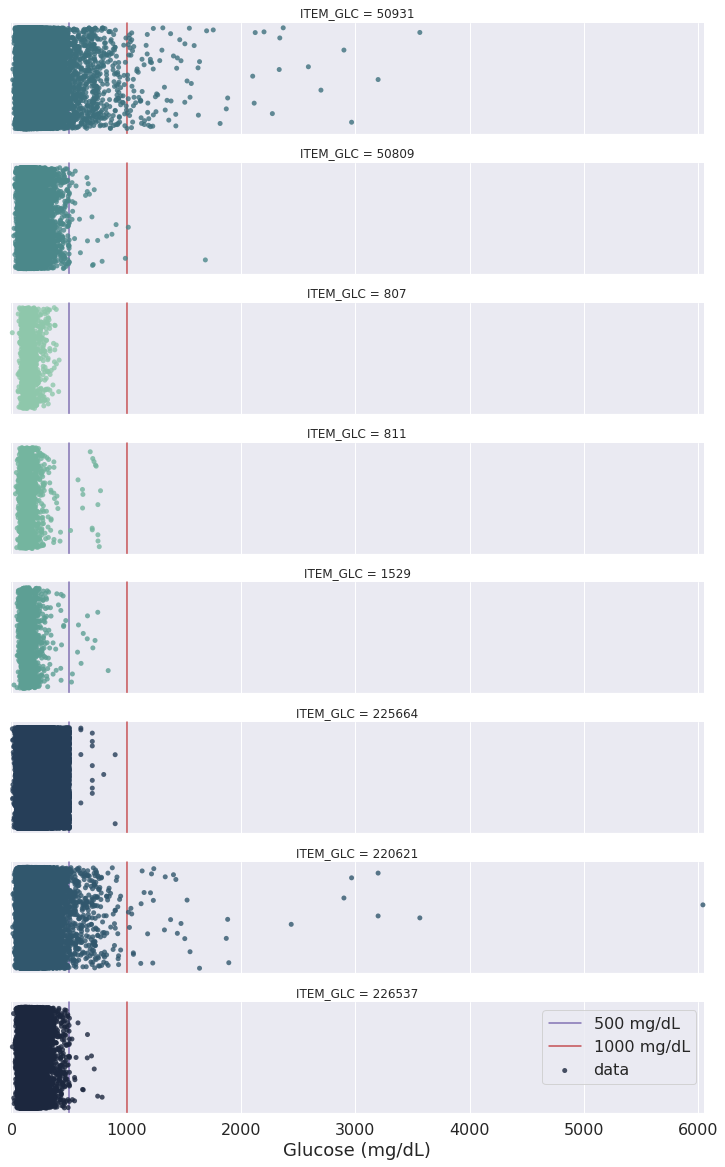

In [ ]:
# Remove duplicated: same subject id, hadm id, and charttime
Glucose_tmp2 = Glucose_tmp.drop_duplicates(["SUBJECT_ID","HADM_ID","CHARTTIME",
                                   "glucose"], keep= 'last').copy(deep=True)
Glucose_tmp2['GLCSOURCE'] = np.nan

# Display information
display(HTML('<h5>Description of all glucose readings</h5>'))
display(Glucose_tmp2[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(Glucose_tmp2.shape[0]))
print("Patients: {}".format(Glucose_tmp2['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_tmp2['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_tmp2['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_tmp2['ITEM_GLC'].value_counts())

# Plot
pal = sns.cubehelix_palette((Glucose_tmp2['ITEM_GLC'].nunique()), rot=-.4, 
                            light=.7)
g = sns.FacetGrid(Glucose_tmp2[Glucose_tmp2.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, 
    row_order=[50931,50809,807,811,1529,225664,220621,226537]
    , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose_tmp2.glucose[Glucose_tmp2.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

#### Fingerstick

In [ ]:
# Filter fingerstick
Glucose_step3_finger = Glucose_tmp2[(Glucose_tmp2['ITEM_GLC'] == 807) | 
        (Glucose['ITEM_GLC'] == 225664) | (Glucose['ITEM_GLC'] == 226537) | 
        (Glucose['ITEM_GLC'] == 811) | (Glucose['ITEM_GLC'] == 1529) ]

# Display statistics (updated)
display(HTML('<h5>Statistics of fingerstick glucose readings</h5>'))
display(Glucose_step3_finger[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(Glucose_step3_finger.shape[0]))
print("Patients: {}".format(Glucose_step3_finger['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_finger['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3_finger['ICUSTAY_ID'].nunique()))

,glucose
count,281334.000000
mean,155.148230
std,1886.097663
min,0.133000
25%,113.000000
50%,138.000000
75%,173.000000
max,999999.000000


Entries: 281334
Patients: 9487
Hospital admissions: 11052
ICU stays: 12024


In [ ]:
warnings.simplefilter('ignore')

# Remove values over 499
Glucose_step3_finger_sat = Glucose_step3_finger[(Glucose_step3_finger['glucose'] < 500)]

# Add flag column
Glucose_step3_finger_sat['GLCSOURCE'] = "FINGERSTICK"

# Display statistics (updated)
display(HTML('<h5>Statistics of fingerstick glucose readings</h5>'))
display(Glucose_step3_finger_sat[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose_step3_finger_sat.shape[0]))
print("Patients: {}".format(Glucose_step3_finger_sat['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_finger_sat['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3_finger_sat['ICUSTAY_ID'].nunique()))

,glucose
count,281189.000000
mean,151.347813
std,59.323179
min,0.133000
25%,113.000000
50%,138.000000
75%,173.000000
max,499.000000


Observations: 281189
Patients: 9486
Hospital admissions: 11050
ICU stays: 12022


#### Laboratory samples

In [ ]:
# Filter
Glucose_step3_blood = Glucose_tmp2[((Glucose_tmp2['ITEM_GLC'] == 3745) | 
        (Glucose_tmp2['ITEM_GLC'] == 220621) | (Glucose_tmp2['ITEM_GLC'] == 50931) | 
        (Glucose_tmp2['ITEM_GLC'] == 50809)
        )]

# Display information
display(HTML('<h5>Description for lab samples</h5>'))
display(Glucose_step3_blood[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(Glucose_step3_blood.shape[0]))
print("Patients: {}".format(Glucose_step3_blood['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_blood['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3_blood['ICUSTAY_ID'].nunique()))

,glucose
count,255821.000000
mean,148.503964
std,1978.198781
min,4.000000
25%,107.000000
50%,129.000000
75%,162.000000
max,999999.000000


Entries: 255821
Patients: 9517
Hospital admissions: 11093
ICU stays: 12121


In [ ]:
# Remove values over 1000
Glucose_step3_blood_sat = Glucose_step3_blood[(Glucose_step3_blood['glucose'] < 1000)]

# Add flag column
Glucose_step3_blood_sat['GLCSOURCE'] = "BLOOD"

# Display statistics (updated)
display(HTML('<h5>Statistics for lab samples</h5>'))
display(Glucose_step3_blood_sat[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose_step3_blood_sat.shape[0]))
print("Patients: {}".format(Glucose_step3_blood_sat['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_blood_sat['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3_blood_sat['ICUSTAY_ID'].nunique()))

,glucose
count,255677.000000
mean,143.834235
std,64.261806
min,4.000000
25%,107.000000
50%,129.000000
75%,162.000000
max,999.000000


Observations: 255677
Patients: 9517
Hospital admissions: 11093
ICU stays: 12121


#### Merging both sources

In [ ]:
warnings.simplefilter('default')

Glucose_step3 = pd.concat([Glucose_step3_finger_sat, Glucose_step3_blood_sat]
, keys=['SUBJECT_ID', 'HADM_ID'], verify_integrity=True
, ignore_index=True)

# Display statistics (updated)
display(HTML('<h5>Statistics for all glucose readings</h5>'))
display(Glucose_step3[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glucose_step3.shape[0]))
print("Patients: {}".format(Glucose_step3['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_step3['ICUSTAY_ID'].nunique()))

,glucose
count,536866.000000
mean,147.769548
std,61.838357
min,0.133000
25%,110.000000
50%,134.000000
75%,168.000000
max,999.000000


Observations: 536866
Patients: 9518
Hospital admissions: 11094
ICU stays: 12224


#### Differences between fingerstick and lab analyzer

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h2>Test normality Ho=normal distribution</h2>'))

# Shapiro-Wilk normality test for Fingerstick
display(HTML('<h3>Shapiro-Wilk normality test for Fingerstick</h3>'))
normality_Finger = stats.shapiro(Glucose_step3_finger_sat['glucose'].dropna())
print('Statistic: {:.2f}; p-value: {:.2f}'.format(normality_Finger[0],normality_Finger[1]))

# Shapiro-Wilk normality test for Lab Analyzer
display(HTML('<h3>Shapiro-Wilk normality test for Lab Analyzer</h3>'))
normality_Lab = stats.shapiro(Glucose_step3_blood_sat['glucose'].dropna())
print('Statistic: {:.2f}; p-value: {:.2f}'.format(normality_Lab[0],normality_Lab[1]))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h2>Excess Kurtosis</h2>'))
# positive kurtosis indicates a "heavy-tailed" distribution and negative kurtosis indicates 
# a "light tailed" distribution.
display("Fingerstick: {:.2f}".format(stats.kurtosis(Glucose_step3_finger_sat['glucose'],
                                                    axis=0, fisher=True, bias=True, 
                                                    nan_policy='omit')))
display("Lab Analyzer: {:.2f}".format(stats.kurtosis(Glucose_step3_blood_sat['glucose'],
                                                    axis=0, fisher=True, bias=True, 
                                                    nan_policy='omit')))
display("All together: {:.2f}".format(stats.kurtosis(Glucose_step3['glucose'],axis=0,
                                                    fisher=True, bias=True, 
                                                    nan_policy='omit')))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h2>Fisher-Pearson coefficient of skewness</h2>'))
display("Fingerstick: {:.2f}".format(stats.skew(Glucose_step3_finger_sat['glucose'], 
                   axis=0, bias=False, nan_policy='omit')))
display("Lab Analyzer: {:.2f}".format(stats.skew(Glucose_step3_blood_sat['glucose'], 
                   axis=0, bias=False, nan_policy='omit')))
display("All together: {:.2f}".format(stats.skew(Glucose_step3['glucose'],
                                                 axis=0,bias=True,nan_policy='omit')))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
countGLCfinger = Glucose_step3_finger_sat.groupby('HADM_ID').count().glucose.copy()
#countGLCfinger.to_csv("CountFingHADM.csv", index=False, encoding='utf8')

countGLClab = Glucose_step3_blood_sat.groupby('HADM_ID').count().glucose.copy()
#countGLClab.to_csv("CountLabHADM.csv", index=False, encoding='utf8')

countGLC = Glucose_step3.groupby('HADM_ID').count().glucose.copy()

display(HTML('<h2>Readings per hospital stay<h2>'))
print("Readings (fingerstick) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLCfinger.mean(),
                                                                       countGLCfinger.std()))
print("Readings (lab analyzer) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLClab.mean(),
                                                                       countGLClab.std()))
print("Readings (both methods) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLC.mean(),
                                                                       countGLC.std()))
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_finger = Glucose_step3_finger_sat.copy(deep=True)
df_finger['diff'] = Glucose_step3_finger_sat.sort_values(['HADM_ID','CHARTTIME']
                                                        ).groupby('HADM_ID')['CHARTTIME'].diff().copy()
df_finger['diff_hr']= df_finger['diff'].dt.seconds/3600
#df_finger.to_csv("Finger_timegap.csv", index=False, encoding='utf8')

df_lab = Glucose_step3_blood_sat.copy(deep=True)
df_lab['diff'] = Glucose_step3_blood_sat.sort_values(['HADM_ID','CHARTTIME']
                                                    ).groupby('HADM_ID')['CHARTTIME'].diff().copy()
df_lab['diff_hr']= df_lab['diff'].dt.seconds/3600
#df_lab.to_csv("Lab_timegap.csv", index=False, encoding='utf8')

df_both = Glucose_step3.copy(deep=True)
df_both['diff'] = Glucose_step3.sort_values(['HADM_ID','CHARTTIME']
                                           ).groupby('HADM_ID')['CHARTTIME'].diff().copy()
df_both['diff_hr']= df_both['diff'].dt.seconds/3600

display(HTML('<h2>Time lapse between readings<h2>'))
print("Time lapse (hr) between bedside fingerstick readings/HADM stay: {:0.2f} +/- {:0.2f}".format(df_finger['diff_hr'].mean(),
                                                                                    df_finger['diff_hr'].std()))
print("Time lapse (hr) between lab analyzer readings/HADM stay: {:0.2f} +/- {:0.2f}".format(df_lab['diff_hr'].mean(),
                                                                             df_lab['diff_hr'].std()))
print("Time lapse (hr) between both readings/HADM stay: {:0.2f} +/- {:0.2f}".format(df_both['diff_hr'].mean(),
                                                                             df_both['diff_hr'].std()))

Statistic: 0.87; p-value: 0.00


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistic: 0.75; p-value: 0.00


'Fingerstick: 4.85'

'Lab Analyzer: 23.65'

'All together: 15.02'

'Fingerstick: 1.79'

'Lab Analyzer: 3.48'

'All together: 2.68'

Readings (fingerstick) per hospital stay: 25.45 +/- 35.66
Readings (lab analyzer) per hospital stay: 23.05 +/- 27.51
Readings (both methods) per hospital stay: 48.39 +/- 58.04


Time lapse (hr) between bedside fingerstick readings/HADM stay: 4.32 +/- 3.85
Time lapse (hr) between lab analyzer readings/HADM stay: 7.07 +/- 7.72
Time lapse (hr) between both readings/HADM stay: 3.94 +/- 4.96


Text(0.5, 0, 'Glucose (mg/dL)')

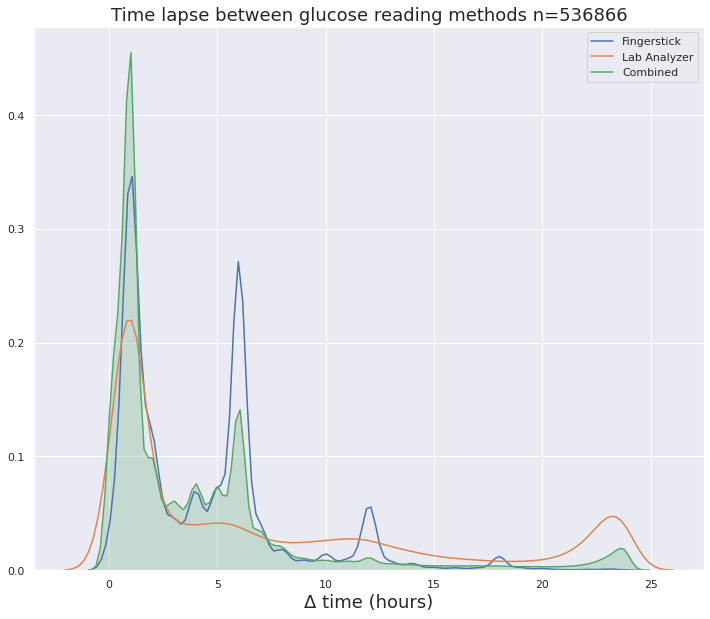

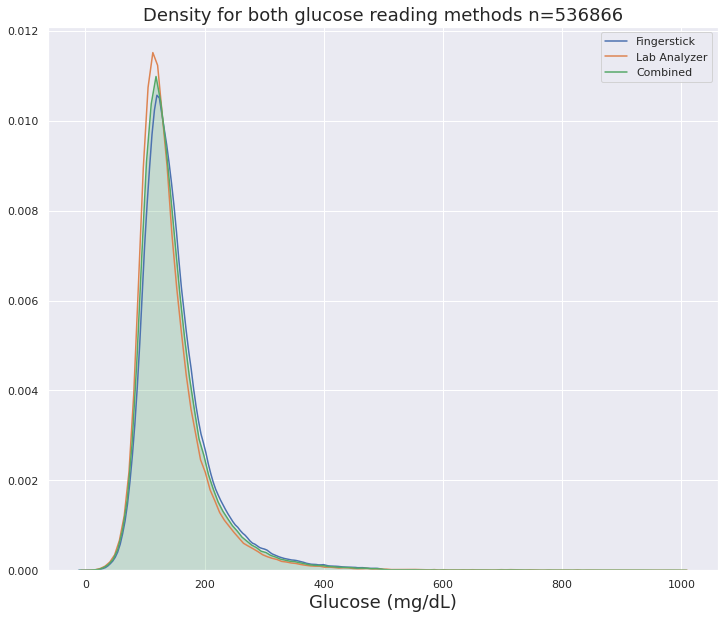

In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Plot TIMEDELTA
plt.figure(figsize=(12,10))
plt.title('Time lapse between glucose reading methods n='+str(df_both.shape[0]),fontsize=18)
sns.kdeplot(df_finger['diff_hr'].dropna(), shade=False, label="Fingerstick")
sns.kdeplot(df_lab['diff_hr'].dropna(), shade=False, label="Lab Analyzer")
sns.kdeplot(df_both['diff_hr'].dropna(), shade=True, label="Combined")
plt.xlabel('\u0394 time (hours)', fontsize=18)
fig = plt.gcf()

# Save figure, uncomment if needed.
#fig.savefig(base_dir+'/DataExtraction/MIMIC_III/Figures/Time_lapse_glc_methods.png')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Plot Glucose readings
plt.figure(figsize=(12,10))
plt.title('Density for both glucose reading methods n='+str(Glucose_step3_finger_sat.shape[0]+
                                                           Glucose_step3_blood_sat.shape[0])
        ,fontsize=18)
sns.kdeplot(Glucose_step3_finger_sat.glucose, shade=False, label="Fingerstick")
sns.kdeplot(Glucose_step3_blood_sat.glucose, shade=False, label="Lab Analyzer")
sns.kdeplot(Glucose_step3.glucose, shade=True, label="Combined")
plt.xlabel('Glucose (mg/dL)', fontsize=18)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Save to CSV. Uncomment as required. DO NOT forget to specify your folder path
# Glucose_step3_finger_sat.to_csv(base_dir+"/DataExtraction/MIMIC_III/GlucoseFingerS3.csv", 
#                                index=False, encoding='utf8')
#Glucose_step3_blood_sat.to_csv(base_dir+"/DataExtraction/MIMIC_III/GlucoseBloodS3.csv", 
#                               index=False, encoding='utf8')

#### CHARTTIME and STORETIME disadjustment

In [ ]:
warnings.simplefilter('ignore')

# Find: (CASE WHEN pt.charttime < pt.storetime THEN pt.charttime ELSE pt.storetime END) AS timer_
Glucose_final = Glucose_step3.copy()
Glucose_final['CHART_STORE'] = Glucose_final['CHARTTIME'] > Glucose_final['STORETIME']

# Create subset for plotting
step4_switch_cases = Glucose_final[(Glucose_final.CHART_STORE == True)].copy()
step4_switch_cases['TIMEDELTA'] = abs(step4_switch_cases.CHARTTIME 
                  - step4_switch_cases.STORETIME).dt.seconds

display(step4_switch_cases.head())

# Replace
Glucose_final.loc[(Glucose_final['CHART_STORE'] == True),
                  'CHARTTIME'] = Glucose_final['STORETIME']

# Display statistics
display(HTML('<h5>Statistics for all glucose readings that got switched their time stamps</h5>'))
display(step4_switch_cases[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(step4_switch_cases.shape[0]))
print("Patients: {}".format(step4_switch_cases['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(step4_switch_cases['HADM_ID'].nunique()))
print('ICU stays: {}'.format(step4_switch_cases['ICUSTAY_ID'].nunique()))

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,STORETIME,glucose,ITEM_GLC,GLCSOURCE,CHART_STORE,TIMEDELTA
2,23,124321.0,234044.0,2157-10-22 10:00:00+00:00,2157-10-22 09:56:00+00:00,188.0,225664,FINGERSTICK,True,240
5,124,138376.0,256064.0,2166-01-10 22:00:00+00:00,2166-01-10 21:31:00+00:00,75.0,225664,FINGERSTICK,True,1740
13,124,138376.0,256064.0,2166-01-13 04:00:00+00:00,2166-01-13 03:32:00+00:00,176.0,226537,FINGERSTICK,True,1680
21,124,138376.0,256064.0,2166-01-14 22:00:00+00:00,2166-01-14 21:46:00+00:00,93.0,225664,FINGERSTICK,True,840
24,124,138376.0,256064.0,2166-01-15 22:00:00+00:00,2166-01-15 21:44:00+00:00,67.0,225664,FINGERSTICK,True,960


,glucose
count,44925.000000
mean,157.314168
std,60.772321
min,1.000000
25%,117.000000
50%,143.000000
75%,181.000000
max,498.000000


Observations: 44925
Patients: 7766
Hospital admissions: 8929
ICU stays: 9479


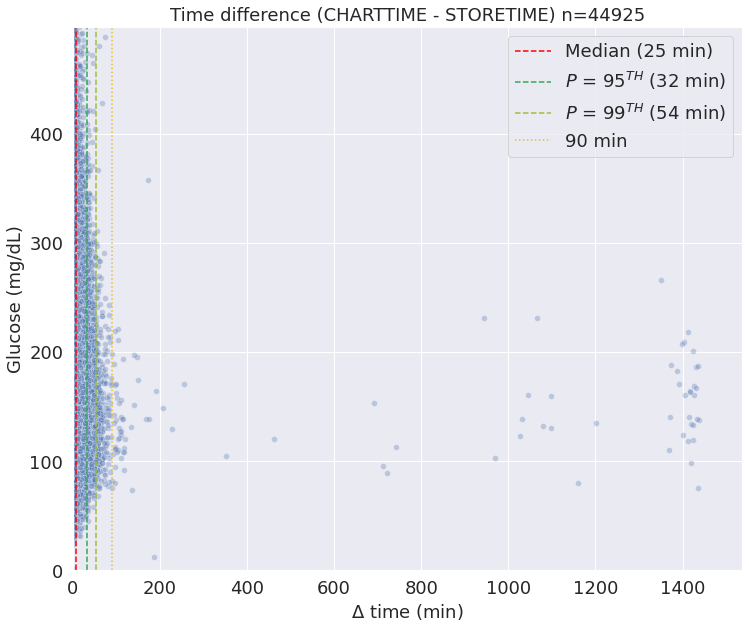

In [ ]:
# Scatterplottimedelta
df = step4_switch_cases.loc[step4_switch_cases['CHART_STORE']==True].copy()
df['TIMEDELTA'] = df['TIMEDELTA']/60

fig = plt.figure(figsize=(12,10))
sns.scatterplot(x="TIMEDELTA",y="glucose",data=df,alpha=0.3)
plt.title('Time difference (CHARTTIME - STORETIME) n='+str(df.shape[0])
        ,fontsize=18)
plt.vlines(df['TIMEDELTA'].quantile(0.50), 0, max(df.glucose)
    , color = 'red', linestyles='--',label='Median (25 min)')
plt.vlines(df['TIMEDELTA'].quantile(0.95), 0, max(df.glucose)
    , color = '#34A853', linestyles='--',label='$P$ = 95$^{TH}$ (32 min)')
plt.vlines(df['TIMEDELTA'].quantile(0.99), 0, max(df.glucose)
    , color = '#9CBF38', linestyles='--',label='$P$ = 99$^{TH}$ (54 min)')
plt.vlines(90, 0, max(df.glucose), color = '#E7BE2D', linestyles='dotted'
           ,label='90 min')
plt.xlabel('$\Delta$ time (min)', fontsize=18)
plt.ylabel('Glucose (mg/dL)', fontsize=18)
plt.ylim(0,(max(df.glucose)))
plt.xlim(0,(max(df.TIMEDELTA)+100))
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.legend(fontsize=18)

# Save figure; uncomment and modify as needed.
#fig.savefig(base_dir+'/DataExtraction/MIMIC_III/Figures/SwitchCHART_STORE.png', 
#            bbox_inches='tight', dpi=fig.dpi)

In [ ]:
# Display statistics for Glucose curated
display(HTML('<h5>Statistics for all curated glucose readings</h5>'))
display(Glucose_final[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(Glucose_final.shape[0]))
print("Patients: {}".format(Glucose_final['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_final['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glucose_final['ICUSTAY_ID'].nunique()))
print("Readings per patient: {:0.2f} +/- {:0.2f}".format(countGLC.mean(),
                                                         countGLC.std()))

# Item id's
print("")
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_final['ITEM_GLC'].value_counts())

,glucose
count,536866.000000
mean,147.769548
std,61.838357
min,0.133000
25%,110.000000
50%,134.000000
75%,168.000000
max,999.000000


Entries: 536866
Patients: 9518
Hospital admissions: 11094
ICU stays: 12224
Readings per patient: 48.39 +/- 58.04



225664    218883
50931     122922
220621     97584
226537     58362
50809      35171
1529        1411
811         1408
807         1125
Name: ITEM_GLC, dtype: int64

## Curated datasets

<Figure size 864x1440 with 0 Axes>

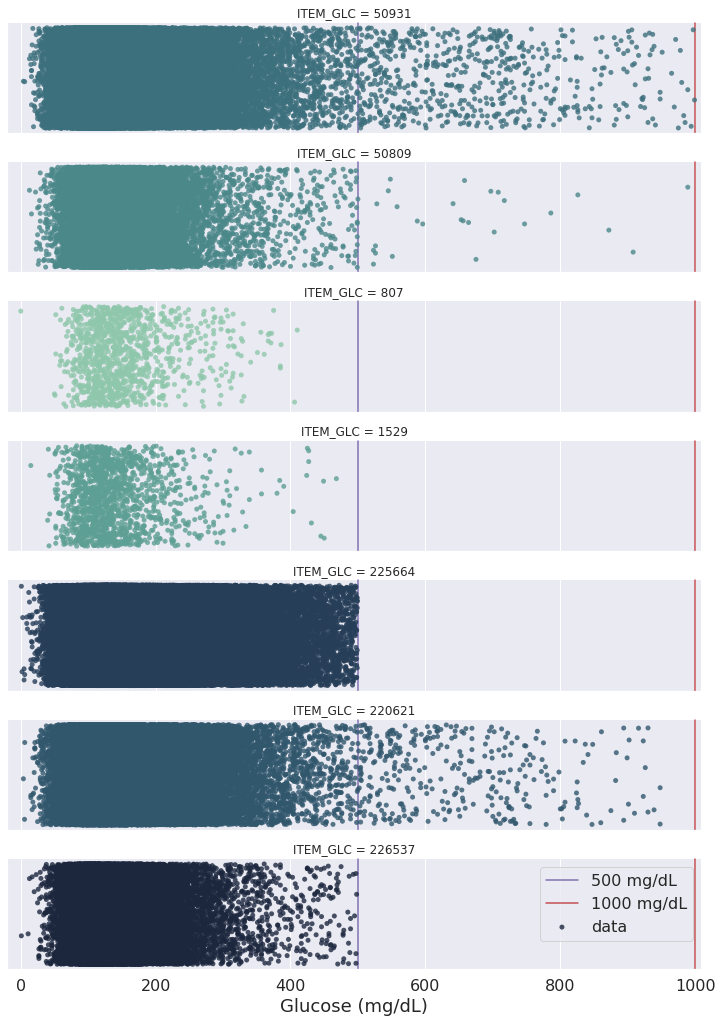

In [ ]:
warnings.simplefilter('ignore')

# Plot
plt.figure(figsize=(12,20))
pal = sns.cubehelix_palette((Glucose_step3['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose_step3[Glucose_step3.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, row_order=[50931,50809,807,1529
                                                                          ,225664,220621,226537]
                 , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose_step3.glucose[Glucose_step3.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)
fig = plt.gcf()
# DO NOT forget to specify your folder path in Google Drive
#fig.savefig(base_dir+'/DataExtraction/MIMIC_III/Figures/ItemsGlucoseFinal.png', 
#          bbox_inches='tight', dpi=fig.dpi)

In [ ]:
warnings.simplefilter('ignore')

# Glucose readings (14 columns)
Glucose_cur = Glucose_final[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','CHARTTIME'
                              ,'glucose','GLCSOURCE','CHART_STORE']].copy(deep=True)
Glucose_cur['STARTTIME'] = pd.NaT
Glucose_cur['ENDTIME'] = pd.NaT
Glucose_cur['INPUT'] = np.nan
Glucose_cur['INPUT_HRS'] = np.nan
Glucose_cur['INSULINTYPE'] = np.nan
Glucose_cur['EVENT'] = np.nan
Glucose_cur['INFXSTOP'] = np.nan

Glucose_cur.columns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'GLCTIMER'
                         , 'GLC', 'GLCSOURCE','CHART_STORE', 'STARTTIME'
                         , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE'
                         , 'EVENT', 'INFXSTOP']

# Insulin events
Insulin_cur = MV_insulin_step6[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'
                               , 'STARTTIME', 'ENDTIME', 'AMOUNT', 'RATE'
                               , 'InsulinType', 'InsulinAdmin', 'INFXSTOP']].copy(deep=True)
Insulin_cur['GLCTIMER'] = pd.NaT
Insulin_cur['GLCSOURCE'] = np.nan
Insulin_cur['GLC'] = np.nan
Insulin_cur['CHART_STORE'] = np.nan

Insulin_cur.columns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME'
                      , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE' 
                      , 'EVENT', 'INFXSTOP', 'CHART_STORE', 'GLCTIMER'
                      , 'GLC','GLCSOURCE']

# Save as CSV file, uncomment and modify as needed.
#Insulin_cur.to_csv(base_dir+"/DataExtraction/MIMIC_III/InsulinInputsCurated.csv", 
#                   index=False, encoding='utf8')

Optional in case you want to save the dataframes as a BigQuery table in your local project. Uncomment as needed.

In [ ]:
# Exporting to BigQuery the table
# DO NOT RE-RUN or otherwise you will be rewritting
client = bigquery.Client(location="US",project="fluent-empire-241300")
print("Client creating using default project: {}".format(client.project))

# Here goes the name of the dataset or schema if you are familiarized with PSQL
dataset_ref = client.dataset('your_dataset')
 
# Assign the name for the tables
table_ref = dataset_ref.table('glcreadings_cur')
#client.load_table_from_dataframe(Glucose_cur, table_ref).result()

del table_ref

table_ref = dataset_ref.table('insulin_cur')
#client.load_table_from_dataframe(Insulin_cur, table_ref).result()

del table_ref

Client creating using default project: fluent-empire-241300


In [ ]:
# Concatenate subsets
warnings.simplefilter('default')

# Concatenate Glucose and insulin values

Glc_Ins = pd.concat([Insulin_cur, Glucose_cur], sort = True, ignore_index = True)

# Reorder columns
Glc_Ins = Glc_Ins[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME'
                      , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE' 
                      , 'EVENT', 'INFXSTOP', 'GLCTIMER', 'GLC', 'GLCSOURCE'
                      , 'CHART_STORE']].sort_values(
                   by=['SUBJECT_ID', 'HADM_ID', 'GLCTIMER', 'STARTTIME'])

Glc_Ins['TIMER'] = pd.NaT

# Reset index
Glc_Ins = Glc_Ins.reset_index()

# Reorder columns
Glc_Ins = Glc_Ins[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'TIMER' ,'STARTTIME'
                      , 'GLCTIMER', 'ENDTIME', 'INPUT', 'INPUT_HRS'
                      , 'INSULINTYPE', 'EVENT', 'GLC', 'GLCSOURCE'
                      , 'CHART_STORE', 'INFXSTOP']].sort_values(
                   by=['SUBJECT_ID', 'HADM_ID', 'GLCTIMER', 'STARTTIME'])

# Create a column that contains all timestamps ordered chronologically
Glc_Ins['TIMER'] = Glc_Ins['GLCTIMER']
Glc_Ins['TIMER'].loc[
        (Glc_Ins['TIMER'].isnull())] = Glc_Ins.loc[
                (Glc_Ins['TIMER'].isnull()),'STARTTIME']
Glc_Ins = Glc_Ins.sort_values(by = ['SUBJECT_ID', 'HADM_ID', 'TIMER'])

display(Glc_Ins.head())

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(Glc_Ins.shape[0]))
print("Patients: {}".format(Glc_Ins['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glc_Ins['HADM_ID'].nunique()))
print('ICU stays: {}'.format(Glc_Ins['ICUSTAY_ID'].nunique()))

# Convert to datetime the columns that contain date and time data
time_cols = ['TIMER', 'STARTTIME', 'GLCTIMER', 'ENDTIME']

Glc_Ins = convert_to_datetime(Glc_Ins,time_cols)

# Save as CSV file; uncomment and modify as needed.
#Glc_Ins.to_csv(base_dir+"/DataExtraction/MIMIC_III/Figures/GlucoseInsulinUNIONALL.csv", 
#               index=False, encoding='utf8')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,TIMER,STARTTIME,GLCTIMER,ENDTIME,INPUT,INPUT_HRS,INSULINTYPE,EVENT,GLC,GLCSOURCE,CHART_STORE,INFXSTOP
0,23,124321.0,NaN,2157-10-19 03:55:00+00:00,NaT,2157-10-19 03:55:00+00:00,NaT,NaN,NaN,NaN,NaN,141.0,BLOOD,False,NaN
1,23,124321.0,NaN,2157-10-20 04:00:00+00:00,NaT,2157-10-20 04:00:00+00:00,NaT,NaN,NaN,NaN,NaN,167.0,BLOOD,False,NaN
2,23,124321.0,NaN,2157-10-21 03:40:00+00:00,NaT,2157-10-21 03:40:00+00:00,NaT,NaN,NaN,NaN,NaN,134.0,BLOOD,False,NaN
3,23,124321.0,NaN,2157-10-21 07:55:00+00:00,NaT,2157-10-21 07:55:00+00:00,NaT,NaN,NaN,NaN,NaN,122.0,BLOOD,False,NaN
4,23,124321.0,NaN,2157-10-21 10:27:00+00:00,NaT,2157-10-21 10:27:00+00:00,NaT,NaN,NaN,NaN,NaN,141.0,BLOOD,False,NaN


Observations: 682560
Patients: 9518
Hospital admissions: 11094
ICU stays: 12224


## INNER JOIN with ICU admissions
In this step, the data that did not occured in the ICU is removed.

In [ ]:
query="""
SELECT * FROM `physionet-data.mimiciii_derived.icustay_detail`
"""

admissions = q(query,projectid)

del query

admissions.rename(columns={"subject_id": "SUBJECT_ID", "hadm_id": "HADM_ID", 
                          "icustay_id": "ICUSTAY_ID", "intime": "ICU_ADMISSIONTIME", 
                          "outtime": "ICU_DISCHARGETIME", "los_icu": "LOS_ICU_days",
                          "first_icu_stay": "first_ICU_stay"},
                 inplace=True)

time_cols = ['admittime', 'dischtime', 'dod', 'ICU_ADMISSIONTIME', 'ICU_DISCHARGETIME']

admissions =  convert_to_datetime(admissions,time_cols)

display(HTML('<h3>ICU admissions<h3>'))

display("Column names: {}".format(list(admissions.columns)))

display(HTML('<h5>Contains the following information</h5>'))
print("Observations: {}".format(admissions.shape[0]))
print("Patients: {}".format(admissions['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(admissions['HADM_ID'].nunique()))
print('ICU stays: {}'.format(admissions['ICUSTAY_ID'].nunique()))
print('Columns: {}'.format(admissions.shape[1]))

"Column names: ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'gender', 'dod', 'admittime', 'dischtime', 'los_hospital', 'admission_age', 'ethnicity', 'admission_type', 'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'ICU_ADMISSIONTIME', 'ICU_DISCHARGETIME', 'LOS_ICU_days', 'icustay_seq', 'first_ICU_stay']"

Observations: 61051
Patients: 46428
Hospital admissions: 57328
ICU stays: 61051
Columns: 19


In [ ]:
# Find duplicated HADM_ID, most likely because more than 1 ICU stay is associated
col_identifiers = ['SUBJECT_ID','HADM_ID' ,'ICUSTAY_ID']

df_unique_hospital = admissions[~admissions.duplicated(
    subset=['HADM_ID'], keep=False)].copy()

df_multi_hospital = admissions[admissions.duplicated(
    subset=['HADM_ID'], keep=False)].copy()

display(HTML('<h4>ICU admissions per hospital admission</h4>'))
print("Total of Hospital admissions: {}".format(admissions['HADM_ID'].nunique()))

display(HTML('<h4>Multiple ICU admissions per hospital admission</h4>'))
print('Hospital admissions with multiple ICU admissions: {}'.format(admissions.loc[
    admissions.duplicated(subset=['HADM_ID'],keep=False),['HADM_ID']].nunique().values))
print("Total entries for multiple ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_multi_hospital.shape[0], 
    df_multi_hospital.ICUSTAY_ID.nunique(), 
    df_multi_hospital.SUBJECT_ID.nunique()))

display(HTML('<h4>One ICU admission per hospital admission</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique_hospital.HADM_ID.nunique()))
print("Total entries for unique ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_unique_hospital.shape[0], 
    df_unique_hospital.ICUSTAY_ID.nunique(), 
    df_unique_hospital.SUBJECT_ID.nunique()))

Total of Hospital admissions: 57328


Hospital admissions with multiple ICU admissions: [3239]
Total entries for multiple ICU admissions: 6962, ICU stays: 6962, Patients: 3101


Hospital admissions with one ICU admission: 54089
Total entries for unique ICU admissions: 54089, ICU stays: 54089, Patients: 44412


In [ ]:
# Inner join with hospital admissions with only one ICU admission
warnings.simplefilter("default")

# INNER JOIN
df_unique = df_unique_hospital[["SUBJECT_ID", "HADM_ID","ICUSTAY_ID",
                                "ICU_ADMISSIONTIME","ICU_DISCHARGETIME",
                                "LOS_ICU_days","first_ICU_stay"]].merge(
    Glc_Ins[['SUBJECT_ID','HADM_ID','TIMER','STARTTIME','GLCTIMER','ENDTIME',
              'INPUT','INPUT_HRS','INSULINTYPE','EVENT','GLC','GLCSOURCE','INFXSTOP']],
    how='inner', on=["SUBJECT_ID", "HADM_ID"]).sort_values(by=['SUBJECT_ID',
                                                               'HADM_ID',
                                                               'TIMER'])

display(HTML('<h4>One ICU admission per hospital admission + glucose readings + insulin inputs</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique.HADM_ID.nunique()))
print("Total entries for unique ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_unique.shape[0], 
    df_unique.ICUSTAY_ID.nunique(), 
    df_unique.SUBJECT_ID.nunique()))

# convert timestamps
time_cols = ['ICU_ADMISSIONTIME', 'ICU_DISCHARGETIME']

for t_col in time_cols:
      df_unique[t_col] = pd.to_datetime(df_unique[t_col], utc=True)

# Drop measurements that occur before or after an ICU stay
df_unique = df_unique[(((df_unique["GLCTIMER"] > df_unique["ICU_ADMISSIONTIME"]) &
                        (df_unique["GLCTIMER"] < df_unique["ICU_DISCHARGETIME"])) |
                       ((df_unique["STARTTIME"] > df_unique["ICU_ADMISSIONTIME"]) &
                        (df_unique["ENDTIME"] < df_unique["ICU_DISCHARGETIME"])))]

display(HTML('<h4>One ICU admission per hospital admission + ICU glucose readings + ICU insulin inputs</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique.HADM_ID.nunique()))
print("Total entries for unique ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_unique.shape[0], 
    df_unique.ICUSTAY_ID.nunique(), 
    df_unique.SUBJECT_ID.nunique()))


Hospital admissions with one ICU admission: 10107
Total entries for unique ICU admissions: 572913, ICU stays: 10107, Patients: 8765


Hospital admissions with one ICU admission: 10107
Total entries for unique ICU admissions: 510917, ICU stays: 10107, Patients: 8765


In [ ]:
# convert timestamps in admissions
time_cols = ['dod', 'admittime','dischtime','ICU_ADMISSIONTIME','ICU_DISCHARGETIME']

for t_col in time_cols:
      admissions[t_col] = pd.to_datetime(admissions[t_col], utc=True)

In [ ]:
# Inner join with hospital admissions with MULTIPLE ICU admissions

df_allids = df_multi_hospital[col_identifiers].drop_duplicates().copy()
HADM_list = df_multi_hospital['HADM_ID'].drop_duplicates().copy()

HADM_list = Glc_Ins.loc[Glc_Ins['HADM_ID'].isin(list(HADM_list)),
                        ['HADM_ID']].drop_duplicates().copy()

i = 0
start_time = time.time()
df_multi = pd.DataFrame([])

for _, row in HADM_list.iterrows():
    #print('HADM_ID {}'.format(row['HADM_ID']))
    # get indexes for row HADM_ID in the dataframe with all 
    # glucose readings and insulin inputs
    idx_HADM_ID = Glc_Ins['HADM_ID']==row['HADM_ID']
    
    # get dataframe with all glucose readings and insulin
    # for row HADM_ID
    df_HADM_ID = Glc_Ins[idx_HADM_ID].copy()
    
    if df_HADM_ID.empty:
        print("Hospital admission not found in the cohort")
        pass
    else:
        df_matched = pd.DataFrame([])
        
        # get indexes for row HADM_ID in the dataframe df_allids
        idx_HADM_allids = df_allids['HADM_ID']==row['HADM_ID']
        
        for _, row2 in df_allids[idx_HADM_allids].iterrows():
            idx_ICUSTAY_admissions = admissions['ICUSTAY_ID'] == row2['ICUSTAY_ID']
            
            # get ADMISSION TIME
            admittime = admissions.loc[
                idx_ICUSTAY_admissions,['ICU_ADMISSIONTIME']].reset_index(drop=True)
            
            # get DISCHARGE TIME
            discharge = admissions.loc[
                idx_ICUSTAY_admissions,['ICU_DISCHARGETIME']].reset_index(drop=True)
            
            # find the values that are after ICU_ADMISSIONT TIME and before ICU_DISCHARGETIME
            # get dataframe with selected ICU
            df_ICUSTAY_ID = df_HADM_ID[(df_HADM_ID.TIMER > admittime.ICU_ADMISSIONTIME[0]) & 
                                       (df_HADM_ID.TIMER < discharge.ICU_DISCHARGETIME[0])].copy()
            
            if df_ICUSTAY_ID.empty:
                print("No information regarding ICU stay {}".format(row2['ICUSTAY_ID']))
                pass
            else:
                # replace ICUSTAY column with the value row2
                # this will fill up missing cells
                df_ICUSTAY_ID['ICUSTAY_ID'] = row2['ICUSTAY_ID']
            
                # append
                df_matched = df_matched.append(df_ICUSTAY_ID)
                #print("Matched {} ICU stays".format(df_allids[idx_HADM_allids].shape[0]))
            
    df_multi = df_multi.append(df_matched)
    
    i+=1
    #print('{} Hospital admissions processed, Time lapse {:0.2f} min'.format(i,(time.time()-start_time)/60))

print('{} Hospital admissions processed, Time lapse {:0.2f} min'.format(i,(time.time()-start_time)/60))
print('Total entries: {}, Columns: {}'.format(df_multi.shape[0], df_multi.shape[1]))

No information regarding ICU stay 240470
No information regarding ICU stay 252923
No information regarding ICU stay 286731
No information regarding ICU stay 221770
No information regarding ICU stay 236355
No information regarding ICU stay 214964
No information regarding ICU stay 275056
No information regarding ICU stay 257867
No information regarding ICU stay 268209
No information regarding ICU stay 298087
No information regarding ICU stay 259838
No information regarding ICU stay 273179
No information regarding ICU stay 270473
No information regarding ICU stay 235741
No information regarding ICU stay 244063
No information regarding ICU stay 267885
No information regarding ICU stay 232777
No information regarding ICU stay 267352
No information regarding ICU stay 286562
No information regarding ICU stay 265441
No information regarding ICU stay 201151
No information regarding ICU stay 204091
No information regarding ICU stay 285633
No information regarding ICU stay 278316
No information r

In [ ]:
# INNER JOIN
df_multi0 = df_multi_hospital[["SUBJECT_ID", "HADM_ID","ICUSTAY_ID",
                              "ICU_ADMISSIONTIME","ICU_DISCHARGETIME",
                              "LOS_ICU_days","first_ICU_stay"]].merge(
    df_multi[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','TIMER','STARTTIME','GLCTIMER',
              'ENDTIME','INPUT','INPUT_HRS','INSULINTYPE','EVENT','GLC','GLCSOURCE',
              'INFXSTOP']],
    how='inner', on=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"]).sort_values(
    by=['SUBJECT_ID','HADM_ID','TIMER'])

display(HTML('<h4>Multiple ICU admission per hospital admission + glucose readings + insulin inputs</h4>'))
print("Hospital admissions with multiple ICU admission: {}".format(
    df_multi0.HADM_ID.nunique()))
print("Total entries for multiple ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_multi0.shape[0], 
    df_multi0.ICUSTAY_ID.nunique(), 
    df_multi0.SUBJECT_ID.nunique()))

Hospital admissions with multiple ICU admission: 987
Total entries for multiple ICU admissions: 92846, ICU stays: 2103, Patients: 954


#### Merge both subsets in one

In [ ]:
# Concatenate df_multi0 and df_unique
ICUinputs = pd.concat([df_unique, df_multi0], ignore_index = True)

display(HTML('<h4>Contains the following information</h4>'))
print("Observations: {}".format(ICUinputs.shape[0]))
print("Patients: {}".format(ICUinputs['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(ICUinputs['HADM_ID'].nunique()))
print('ICU stays: {}'.format(ICUinputs['ICUSTAY_ID'].nunique()))
print('Columns: {}'.format(ICUinputs.shape[1]))

# Save as CSV file; uncomment and modify as needed.
#ICUinputs.to_csv(base_dir+"/DataExtraction/MIMIC_III/glucose_insulin_ICU.csv", 
#                 index=False, encoding='utf8')

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:476: ResourceWarning: unclosed <ssl.SSLSocket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 39776), raddr=('108.177.111.95', 443)>
  return lambda x: Timestamp(x, freq=self.freq, tz=self.tz)
/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:476: ResourceWarning: unclosed <ssl.SSLSocket fd=83, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 60298), raddr=('209.85.234.95', 443)>
  return lambda x: Timestamp(x, freq=self.freq, tz=self.tz)


Observations: 603763
Patients: 9518
Hospital admissions: 11094
ICU stays: 12210
Columns: 18


#### Descriptive statistics and counts

In [ ]:
# Display statistics
display(HTML('<h5>Statistics of insulin doses and glucose readings once merged</h5>'))
display(ICUinputs[['INPUT','INPUT_HRS','GLC']].describe())

# Insulin inputs
df = ICUinputs.dropna(subset=['STARTTIME']).copy(deep=True)
short_boluses_icu = df[(df['INSULINTYPE']=="Short") & 
                       ((df['EVENT'].str.contains('BOLUS'))==True)].shape[0]
intermediate_boluses_icu = df[(df['INSULINTYPE']=="Intermediate") & 
                              ((df['EVENT'].str.contains('BOLUS'))==True)].shape[0]
long_boluses_icu = df[(df['INSULINTYPE']=="Long") & 
                      ((df['EVENT'].str.contains('BOLUS'))==True)].shape[0]

# Display results
display(HTML('<h4>Insulin inputs</h4>'))
print("Entries: {}".format(df.shape[0]))
print("Patients: {}".format(df['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(df['HADM_ID'].nunique()))
print('ICU stays: {}'.format(df['ICUSTAY_ID'].nunique()))
print("Short acting boluses: {}".format(short_boluses_icu))
print("Intermediate acting boluses: {}".format(intermediate_boluses_icu))
print("Long acting boluses: {}".format(long_boluses_icu))

# Administration route
display(HTML('<h5>Administration routes:</h5>'))
display(ICUinputs['EVENT'].value_counts())

# Glucose readings
finger_icu = ICUinputs[ICUinputs['GLCSOURCE']=='FINGERSTICK'].copy(deep=True)
blood_icu = ICUinputs[ICUinputs['GLCSOURCE']=='BLOOD'].copy(deep=True)

display(HTML('<h4>Glucose sampling:</h4>'))
display(ICUinputs['GLCSOURCE'].value_counts())

display(HTML('<h5>Fingerstick:</h5>'))
display(finger_icu['GLC'].describe())

display(HTML('<h5>Lab analyzer:</h5>'))
display(blood_icu['GLC'].describe())

,INPUT,INPUT_HRS,GLC
count,145678.000000,44631.000000,458085.000000
mean,7.635692,4.985731,148.833633
std,9.840959,4.164922,60.017181
min,0.000833,0.003418,0.133000
25%,2.000000,2.000681,112.000000
50%,4.000000,4.000000,135.000000
75%,8.246813,6.006279,169.000000
max,180.000000,29.812108,948.000000


Entries: 145678
Patients: 9517
Hospital admissions: 11093
ICU stays: 11724
Short acting boluses: 88460
Intermediate acting boluses: 3962
Long acting boluses: 8625


BOLUS_INYECTION    91748
INFUSION           44631
BOLUS_PUSH          9299
Name: EVENT, dtype: int64

FINGERSTICK    280692
BLOOD          177393
Name: GLCSOURCE, dtype: int64

count    280692.000000
mean        151.316964
std          59.286584
min           0.133000
25%         113.000000
50%         138.000000
75%         173.000000
max         499.000000
Name: GLC, dtype: float64

count    177393.000000
mean        144.904217
std          60.949190
min           4.000000
25%         109.000000
50%         131.000000
75%         163.000000
max         948.000000
Name: GLC, dtype: float64

Confirm number of entries: 12210



LOS minimum: 0.0
LOS maximum: 102.0
LOS mean: 11.98 +/- 12.98
LOS median: 7.0
LOS mode: 1.0
LOS frequency of mode: 64480
Percentage of ICU stays that are within the mode: 10.68%

Instances less than 1 day: 568
Percentage of less than 1 day: 0.09%

LOS frequency >=1 day: 603195
ICU stays in day 1: 64480

LOS frequency >=2 days: 538715
ICU stays in day 2: 62521

LOS frequency >=3 days: 476194
ICU stays in day 3: 53105

LOS frequency >=4 days: 423089
ICU stays in day 4: 39679

LOS frequency >=5 days: 383410
ICU stays in day 5: 33725

LOS frequency >=6 days: 349685
ICU stays in hour 6: 26418

LOS frequency >=7 days: 323267
ICU stays in hour 7: 22558
Percentage of less than 1 week: 50.19%

LOS frequency >=8 days: 300709
ICU stays in day 8: 22099

LOS frequency >=10 days: 256429
ICU stays in day 10: 17741

LOS frequency >=24 days: 88648
Percentage of ICU stays with 24 days or more: 14.68%

LOS frequency >=48 days: 14579
Percentage of ICU stays with 48 days or more: 2.41%


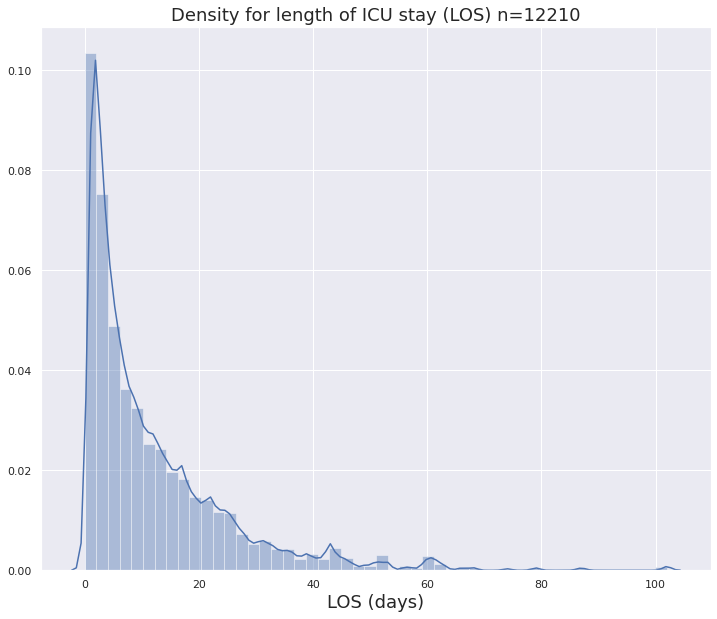

In [ ]:
ICUtmp = ICUinputs.copy(deep=True)
print("Confirm number of entries: {}".format(ICUtmp.ICUSTAY_ID.nunique()))
print("")

# LOS
display(HTML('<h4>Length of stay in the ICU:</h4>'))
print("LOS minimum: {}".format(ICUtmp['LOS_ICU_days'].min()))
print("LOS maximum: {}".format(ICUtmp['LOS_ICU_days'].max()))
print("LOS mean: {:0.2f} +/- {:0.2f}".format(ICUtmp['LOS_ICU_days'].mean(),ICUtmp['LOS_ICU_days'].std()))
print("LOS median: {}".format(ICUtmp['LOS_ICU_days'].median()))
print("LOS mode: {}".format(ICUtmp['LOS_ICU_days'].mode()[0]))
print("LOS frequency of mode: {}".format(len(ICUtmp.loc[ICUtmp['LOS_ICU_days']==ICUtmp['LOS_ICU_days'].mode()[0],'LOS_ICU_days'])))
print("Percentage of ICU stays that are within the mode: {:0.2f}%".format(
    (len(ICUtmp.loc[ICUtmp['LOS_ICU_days']==ICUtmp['LOS_ICU_days'].mode()[0],
                    'LOS_ICU_days']))/ICUtmp.shape[0]*100) )
print("")
print("Instances less than 1 day: {}".format(len(ICUtmp.loc[ICUtmp['LOS_ICU_days']<1,'LOS_ICU_days'])))
print("Percentage of less than 1 day: {:0.2f}%".format(len(ICUtmp.loc[ICUtmp['LOS_ICU_days']<1,
                                                                       'LOS_ICU_days'])/ICUtmp.shape[0]*100))
print("")
print("LOS frequency >=1 day: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=1,'LOS_ICU_days'])))
print("ICU stays in day 1: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=1,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=2,'LOS_ICU_days'])))
print("")
print("LOS frequency >=2 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=2,'LOS_ICU_days'])))
print("ICU stays in day 2: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=2,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=3,'LOS_ICU_days'])))
print("")
print("LOS frequency >=3 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=3,'LOS_ICU_days'])))
print("ICU stays in day 3: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=3,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=4,'LOS_ICU_days'])))
print("")
print("LOS frequency >=4 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=4,'LOS_ICU_days'])))
print("ICU stays in day 4: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=4,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=5,'LOS_ICU_days'])))
print("")
print("LOS frequency >=5 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=5,'LOS_ICU_days'])))
print("ICU stays in day 5: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=5,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=6,'LOS_ICU_days'])))
print("")
print("LOS frequency >=6 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=6,'LOS_ICU_days'])))
print("ICU stays in hour 6: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=6,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=7,'LOS_ICU_days'])))
print("")
print("LOS frequency >=7 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=7,'LOS_ICU_days'])))
print("ICU stays in hour 7: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=7,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=8,'LOS_ICU_days'])))
print("Percentage of less than 1 week: {:0.2f}%".format(
    len(ICUtmp.loc[ICUtmp['LOS_ICU_days']<=7,
                   'LOS_ICU_days'])/ICUtmp.shape[0]*100))
print("")
print("LOS frequency >=8 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=8,'LOS_ICU_days'])))
print("ICU stays in day 8: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=8,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=9,'LOS_ICU_days'])))
print("")
print("LOS frequency >=10 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=10,'LOS_ICU_days'])))
print("ICU stays in day 10: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=10,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=11,'LOS_ICU_days'])))
print("")
print("LOS frequency >=24 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=24,'LOS_ICU_days'])))
print("Percentage of ICU stays with 24 days or more: {:0.2f}%".format(
    (len(ICUtmp.loc[ICUtmp['LOS_ICU_days']>=24,'LOS_ICU_days']))/ICUtmp.shape[0]*100) )
print("")
print("LOS frequency >=48 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=48,'LOS_ICU_days'])))
print("Percentage of ICU stays with 48 days or more: {:0.2f}%".format(
    (len(ICUtmp.loc[ICUtmp['LOS_ICU_days']>=48,'LOS_ICU_days']))/ICUtmp.shape[0]*100) )


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Plot
plt.figure(figsize=(12,10))
plt.title('Density for length of ICU stay (LOS) n='+str(ICUtmp.ICUSTAY_ID.nunique())
          ,fontsize=18)
#sns.kdeplot(ICUtmp.LOS_ICU_days, shade=True, label="LOS")
sns.distplot(ICUtmp.LOS_ICU_days, label="LOS")
plt.xlabel('LOS (days)', fontsize=18)
fig = plt.gcf()

# Save figure; uncomment and modify as needed.
#fig.savefig(base_dir+'/DataExtraction/MIMIC_III/Figures/LOS_12210.png', 
#          bbox_inches='tight', dpi=fig.dpi)

In [ ]:
# Glucose readings/ICU stay

admissions['LOS_ICU_min'] = (admissions['ICU_DISCHARGETIME']-
                             admissions['ICU_ADMISSIONTIME'])/np.timedelta64(1, 'm')

admissions.loc[admissions.index[np.isnan(admissions['LOS_ICU_min'])],
               'LOS_ICU_min'] = (admissions['dischtime']-
                                 admissions['ICU_ADMISSIONTIME'])/np.timedelta64(1, 'm')

def reading_hourICUstay(df):
    # Merge admissions with df
    # Size would reduce because we are removing those outside ICU
    df3 = admissions[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOS_ICU_min']].merge(
        df[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','glucose']], 
        how ='inner', on=["SUBJECT_ID","HADM_ID","ICUSTAY_ID"]).sort_values(
        by=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])
    
    # Count glucose readings
    count_glucose = df3.groupby('ICUSTAY_ID').count().glucose
    # Extract LOS
    LOS = df3.groupby('ICUSTAY_ID').mean().LOS_ICU_min
    # Create empty dataframe
    df2 = pd.DataFrame()
    # Divide number of readings/LOS
    df2['read_minICU'] = count_glucose/LOS
    
    return df2

df_read_min_both = reading_hourICUstay(df_both)
df_read_min_finger = reading_hourICUstay(df_finger)
#df_read_min_finger.to_csv("ReadMinute_Finger.csv", index=False, encoding='utf8')
df_read_min_lab = reading_hourICUstay(df_lab)
#df_read_min_lab.to_csv("ReadMinute_Lab.csv", index=False, encoding='utf8')

d = 2;

display(HTML('<h2>Glucose readings per minute per ICU stay<h2>'))
print("Readings per minute in both methods: {:0.5f} +/- {:0.5f}, that means {:0.2f} +/- {:0.2f} readings every {} hours".format(
    df_read_min_both.read_minICU.mean(),
    df_read_min_both.read_minICU.std(),
    df_read_min_both.read_minICU.mean()*60*d,df_read_min_both.read_minICU.std()*60*d,d))
print("Readings per minute for fingerstick: {:0.5f} +/- {:0.5f}, that means {:0.2f} +/- {:0.2f} readings every {} hours".format(
    df_read_min_finger.read_minICU.mean(),
    df_read_min_finger.read_minICU.std(),
    df_read_min_finger.read_minICU.mean()*60*d,df_read_min_finger.read_minICU.std()*60*d,d))
print("Readings per minute for lab analyzer: {:0.5f} +/- {:0.5f}, that means {:0.2f} +/- {:0.2f} readings every {} hours".format(
    df_read_min_lab.read_minICU.mean(),
    df_read_min_lab.read_minICU.std(),
    df_read_min_lab.read_minICU.mean()*60*d,df_read_min_lab.read_minICU.std()*60*d,d))

Readings per minute in both methods: 0.00515 +/- 0.00333, that means 0.62 +/- 0.40 readings every 2 hours
Readings per minute for fingerstick: 0.00406 +/- 0.00328, that means 0.49 +/- 0.39 readings every 2 hours
Readings per minute for lab analyzer: 0.00116 +/- 0.00062, that means 0.14 +/- 0.07 readings every 2 hours


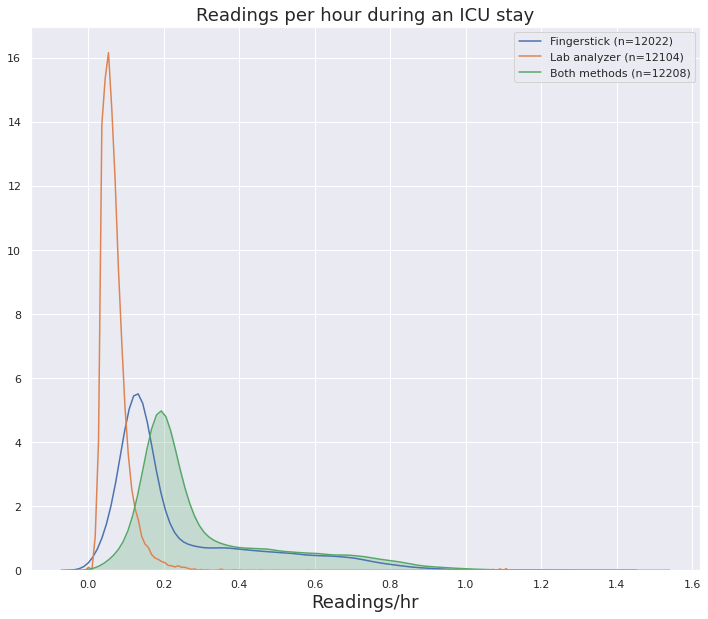

In [ ]:
# Plot
plt.figure(figsize=(12,10))
plt.title('Readings per hour during an ICU stay', fontsize=18)
sns.kdeplot(df_read_min_finger.read_minICU*60, shade=False,
             label="Fingerstick (n="+str(df_read_min_finger.shape[0])+")")
sns.kdeplot(df_read_min_lab.read_minICU*60, shade=False,
             label="Lab analyzer (n="+str(df_read_min_lab.shape[0])+")")
sns.kdeplot(df_read_min_both.read_minICU*60, shade=True,
             label="Both methods (n="+str(df_read_min_both.shape[0])+")")
plt.xlabel('Readings/hr', fontsize=18)
fig = plt.gcf()
# Save figure; uncomment and modify as needed.
#fig.savefig(base_dir+'/DataExtraction/MIMIC_III/Figures/Readings_hour_glc_methods.png', 
#          bbox_inches='tight', dpi=fig.dpi)

In [ ]:
# Import icustaydetails for age
projectid = "hst-953-2019" # <-- Here goes your project ID
query="""SELECT SUBJECT_ID, HADM_ID, ICUSTAY_ID, DOD, admission_age 
FROM `physionet-data.mimiciii_derived.icustay_detail`"""

icudetails = q(query,projectid)

del query

display(HTML('<h4>Contains the following information</h4>'))
print("Observations: {}".format(icudetails.shape[0]))
print("Patients: {}".format(icudetails['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(icudetails['HADM_ID'].nunique()))
print('ICU stays: {}'.format(icudetails['ICUSTAY_ID'].nunique()))

Observations: 61051
Patients: 46428
Hospital admissions: 57328
ICU stays: 61051


In [ ]:
# Age of patients that got glycemia measured trough fingerstick/lab analyzer

def AGEICUstay(df):
    # Merge admissions with df
    # Size would reduce because we are removing those outside ICU
    df3 = icudetails[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','admission_age']].merge(
        df[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','glucose']], 
        how ='inner', on=["SUBJECT_ID","HADM_ID","ICUSTAY_ID"]).sort_values(
        by=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])
    
    # Extract AGE
    AGE = df3.groupby('ICUSTAY_ID').mean().admission_age
    
    return AGE

df_AGE_both = AGEICUstay(df_both)
df_AGE_finger = AGEICUstay(df_finger)
#df_AGE_finger.to_csv("AgeFinger.csv", index=False, encoding='utf8', header = 'VarName')
df_AGE_lab = AGEICUstay(df_lab)
#df_AGE_lab.to_csv("AgeLab.csv", index=False, encoding='utf8', header = 'VarName')

display(HTML('<h2>Age of patients per method of reading<h2>'))
print("Age of patients in both methods: {:0.2f} +/- {:0.2f}".format(
    df_AGE_both.mean(),df_AGE_both.std()))
print("Age of patients in figerstick: {:0.2f} +/- {:0.2f}".format(
    df_AGE_finger.mean(),df_AGE_finger.std()))
print("Age of patients in lab analyzer: {:0.2f} +/- {:0.2f}".format(
    df_AGE_lab.mean(),df_AGE_lab.std()))


Age of patients in both methods: 72.56 +/- 45.49
Age of patients in figerstick: 72.57 +/- 45.56
Age of patients in lab analyzer: 72.54 +/- 45.47


## Export to BigQuery (*Optional*)
In case you want to save it to your local project. Uncomment and substitute `your_dataset`with the name of your dataset to execute.

Contains the merged information of curated glucose readings and curated insulin inputs. Created from this notebook. This table is equivalent to *glucose_insulin_ICU.csv*

In [ ]:
# Exporting to BigQuery the table
# DO NOT RE-RUN or otherwise you will be rewritting
# Same table as glucose_insulin_ICU.csv
# Assign the name for the table
table_ref = dataset_ref.table('glc_cur0ins_cur')
#client.load_table_from_dataframe(ICUinputs, table_ref).result()

del table_ref

In [ ]:
# Exporting to BigQuery the table
# DO NOT RE-RUN or otherwise you will be rewritting
client = bigquery.Client(location="US",project=projectid)
print("Client creating using default project: {}".format(client.project))

# Here goes the name of the dataset or schema if you are familiarized with PSQL
dataset_ref = client.dataset('your_dataset')
 
# Assign the name for the table
table_ref = dataset_ref.table('glc_finger_cur')
#client.load_table_from_dataframe(Glucose_step3_finger_sat, table_ref).result()

del table_ref

table_ref = dataset_ref.table('glc_blood_cur')
#client.load_table_from_dataframe(Glucose_step3_blood_sat, table_ref).result()

del table_ref

Client creating using default project: fluent-empire-241300


# Run *2.0-ara-pairing-II.ipynb* to pair glucose readings and insulin inputs.